In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sasmol.sasmol as sasmol
from lib._cLoops import ffi, lib
from lennard_gofr import *
import matplotlib as mpl
from GV import *
import cPickle as pickle

# Style plots
plt.style.use('ggplot')
mpl.rcParams['figure.figsize']=(16,9)
mpl.rcParams['font.size']=20
mpl.rcParams['axes.labelsize']=25
mpl.rcParams['axes.titlesize']=25
mpl.rcParams['figure.titlesize']=25
mol = sasmol.SasMol(0)
mol.read_pdb('Data/run_0.pdb')
mol.read_dcd('Data/run_1.dcd')


IOError: [Errno 2] No such file or directory: 'Data/run_0.pdb'

In [2]:
def getAverage(arr):
    if type(arr) is np.ndarray:
        return np.mean(arr,axis=0)
    elif type(arr) is list:
        return np.mean(np.array([i for i in arr]),axis=0)
    else:
        raise TypeError('arr was not list or ndarry')

In [3]:
exp_I = np.load('/home/data/Outputs/2016-07-16_00-24/outPutI-Q250.npy')
exp_Q = np.logspace(-1,1.6,250)

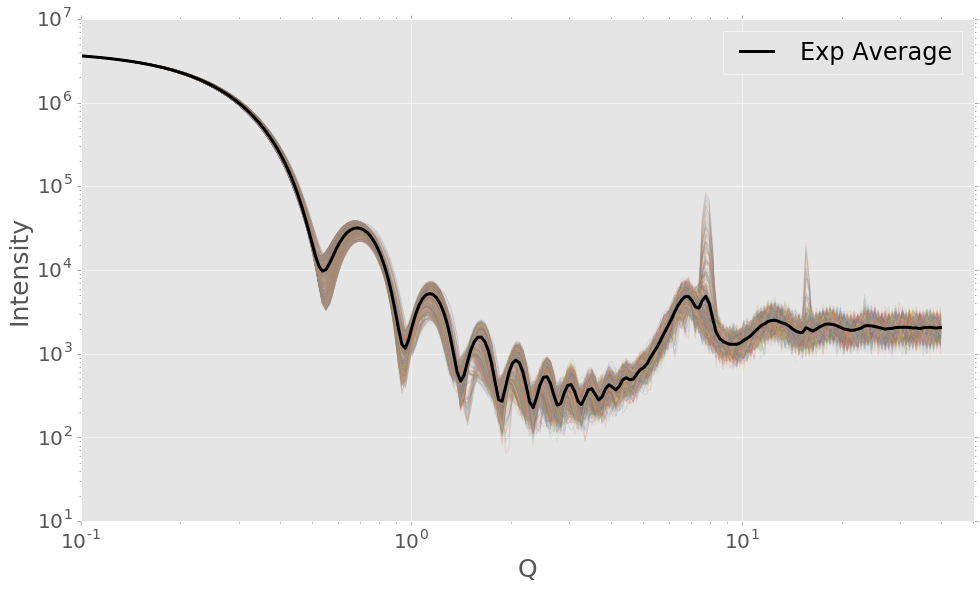

In [4]:
for i in exp_I:
    plt.loglog(exp_Q,i,alpha=.15)
exp_avg = getAverage(exp_I)
plt.loglog(exp_Q,exp_avg,'k-',lw=3,label='Exp Average')
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.xlim([10**-1,10**1.7])
plt.show()

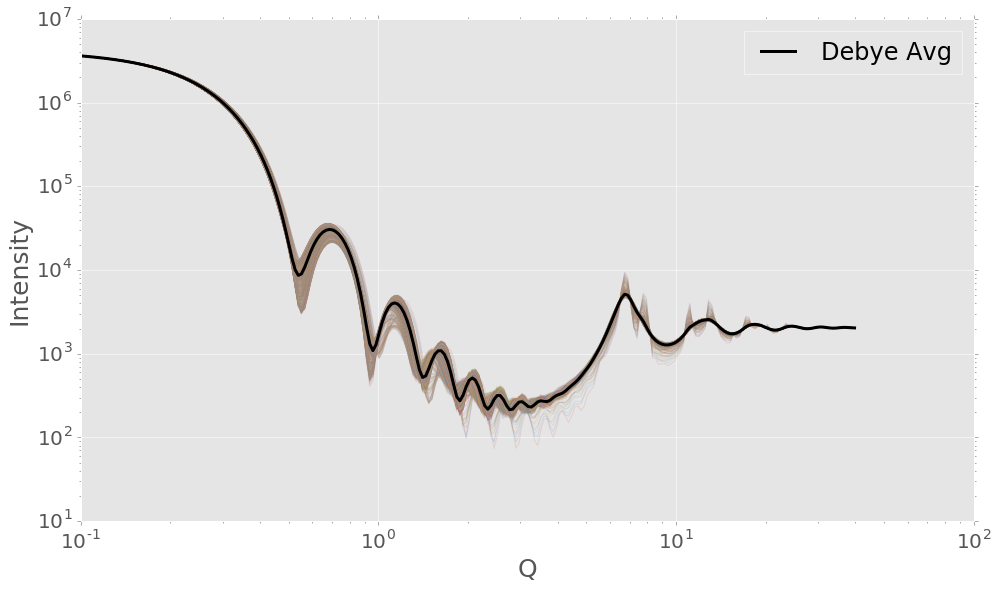

In [5]:
debye_I = np.load('/home/data/Outputs/2016-07-19_12-49/outPutI-Q250.npy')
debye_Q = np.load('/home/data/Outputs/2016-07-19_12-49/Q_list.npy')
debye_avg = getAverage(debye_I)
for i in debye_I:
    plt.loglog(debye_Q, i,alpha=.15)
plt.loglog(debye_Q,debye_avg,'k-',label='Debye Avg',lw=3)
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.show()

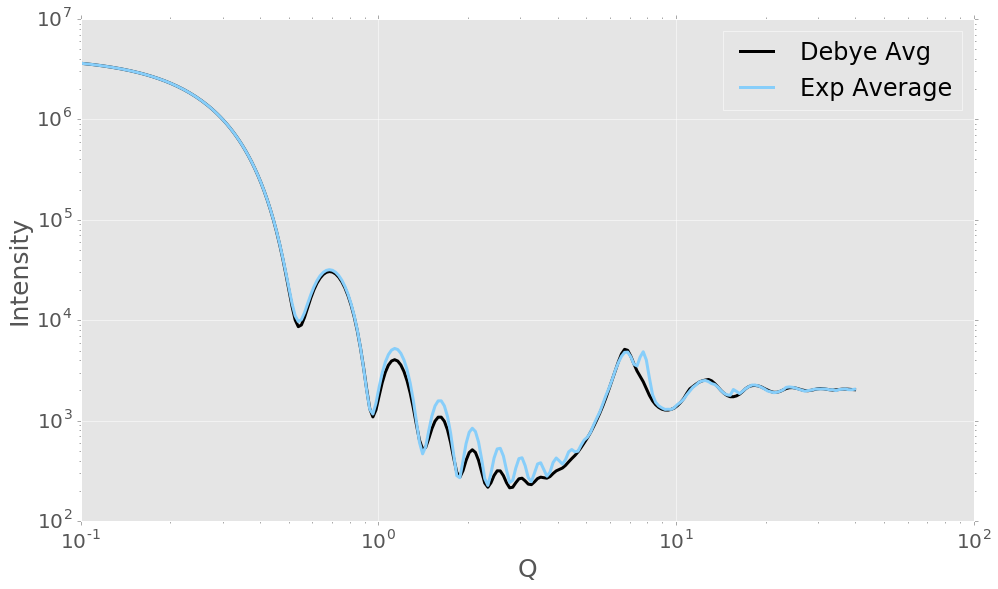

In [6]:
plt.loglog(debye_Q,debye_avg,'k-',label='Debye Avg',lw=3)
plt.loglog(exp_Q,exp_avg,'-',color='lightskyblue',lw=3,label='Exp Average')
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.show()

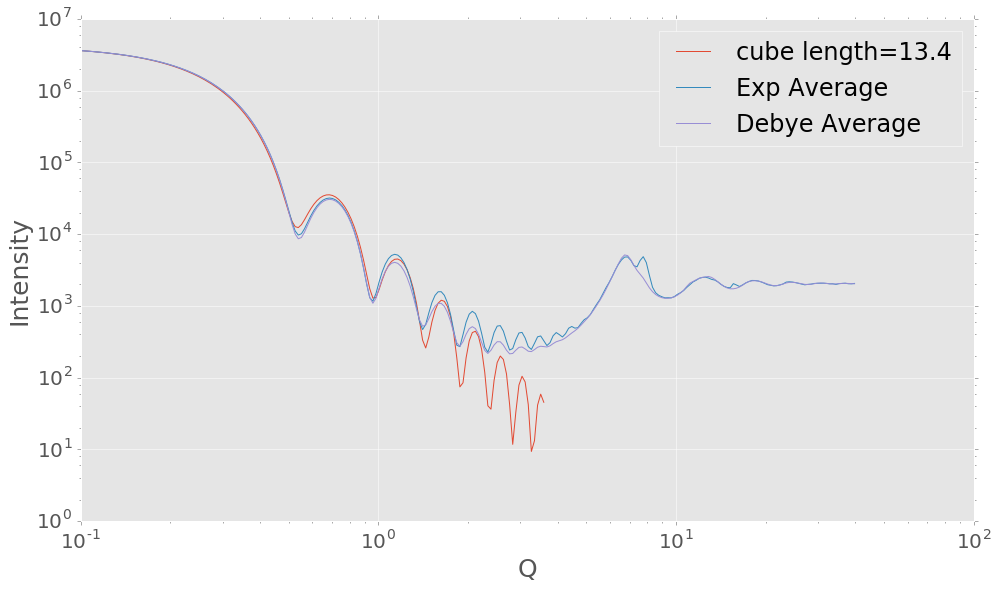

In [7]:
def cubeScatt(q, box = 13.4):
    from _cube import lib
    I_cube = np.zeros_like(q)

    for i,Q in enumerate(q):
        I_cube[i] = lib.Iq(Q,10,0,box,box,box)
    return I_cube
box = 13.4
I_cube = cubeScatt(exp_Q,box)
cut=100
plt.loglog(exp_Q[:-cut],(I_cube/I_cube[0]*exp_avg[0])[:-cut],label='cube length='+str(box))
plt.loglog(exp_Q,exp_avg,label='Exp Average')
plt.loglog(debye_Q,debye_avg,label='Debye Average')

plt.ylabel('Intensity')
plt.xlabel('Q')
plt.legend()

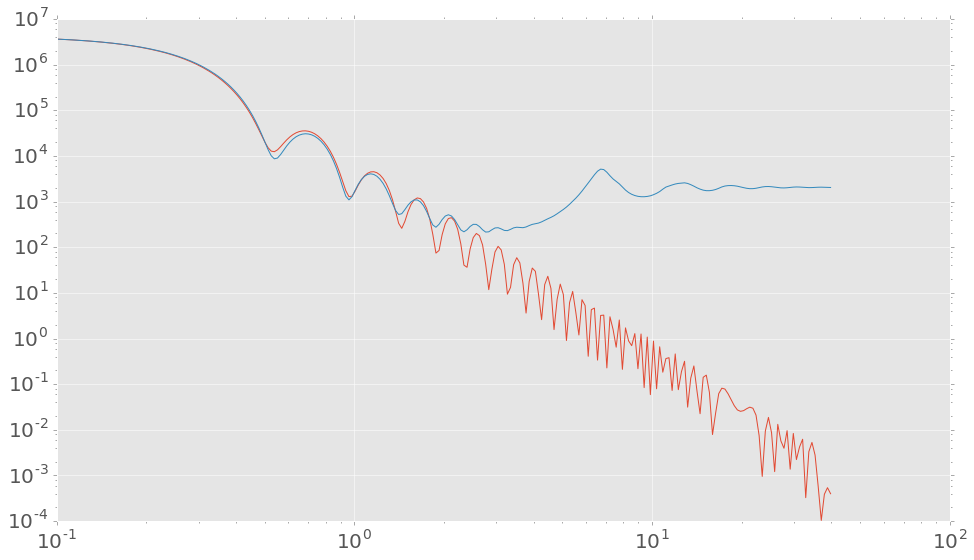

In [8]:
I_cube = cubeScatt(debye_Q,box)
I_cube *= debye_avg[0]/I_cube[0]
plt.loglog(debye_Q,I_cube)
plt.loglog(debye_Q,debye_avg)



# Fit Debye

In [9]:
from lmfit import Model
mod = Model(cubeScatt)
?mod.fit

In [74]:
def myResids(res,Q,full_data):
    cut = len(full_data)-len(res.data)
    fig = plt.figure()
    gs = plt.GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 4])
    ax_res = fig.add_subplot(gs[0])
    ax_res_log = fig.add_subplot(gs[1])
    ax_fit = fig.add_subplot(gs[2], sharex=ax_res)

    ax_res.plot(Q[:-cut],res.eval()-res.data,'ro')
    ax_res_log.loglog(Q[:-cut],np.abs(res.eval()-res.data),'ro')
    ax_fit.loglog(Q,full_data)
    ax_fit.loglog(Q[:-cut],res.best_fit)
    padded = np.pad(res.best_fit,(0,cut),'constant',constant_values=0)
    ax_fit.loglog(Q,full_data-padded)
    plt.show()

def doFit(Q,data,cut=80,func=None,pars=None):

    from lmfit import Model, Parameters
    from warnings import warn
    if func is None:
        def cubeScatt(q, box = 13.4,bkg=0):
            from _cube import lib
            I_cube = np.zeros_like(q)

            for i,Q in enumerate(q):
                I_cube[i] = lib.Iq(Q,10,0,box,box,box)+bkg
            return I_cube*data[0]/I_cube[0]
        func = cubeScatt
        pars = Parameters()
        pars.add('box',value=13.4)
        #pars.add('bkg',value=min(data[:-cut]))
        pars.add('bkg',value=0,vary=False)

    mod = Model(func)
    if pars is None:
        warn("parameters may be bad guess")
        plt.show()
        pars = mod.make_params()
    res = mod.fit(data[:-cut],pars,q=Q[:-cut])#,weights=(1./data[:-cut])*10**4)
    fig = res.plot()
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_xlim([0,max(Q[:-cut])])
#     ax.set_ylim([10**1,10**7])
    plt.show()
    print(res.fit_report())
    return res

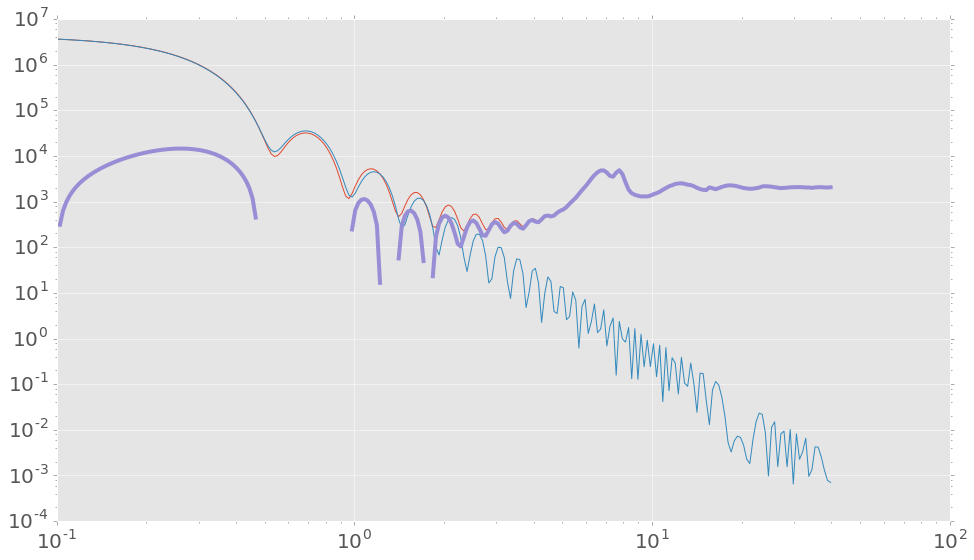

In [75]:
def cubeScatt(q, box = 13.4,bkg=0):
    from _cube import lib
    I_cube = np.zeros_like(q)

    for i,Q in enumerate(q):
        I_cube[i] = lib.Iq(Q,10,0,box,box,box)+bkg
    return I_cube
cubeI = cubeScatt(exp_Q,box=13.2837,bkg=0)
plt.loglog(exp_Q,exp_avg)
plt.loglog(exp_Q,cubeI*exp_avg[0]/cubeI[0])
plt.loglog(exp_Q,exp_avg-cubeI*exp_avg[0]/cubeI[0],lw=4)


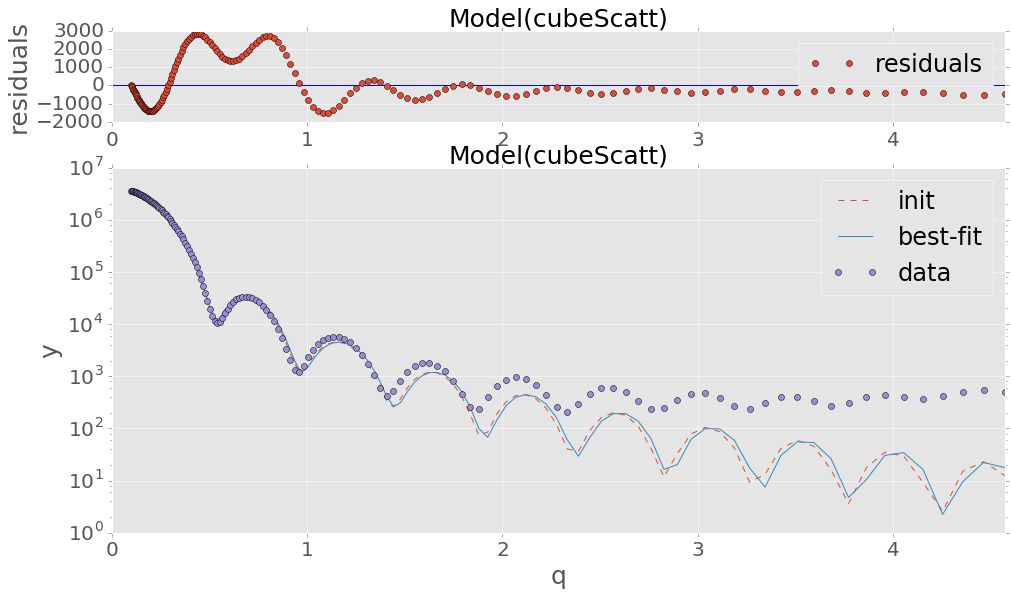

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 160
    # variables        = 1
    chi-square         = 266385818.656
    reduced chi-square = 1675382.507
    Akaike info crit   = 2295.048
    Bayesian info crit = 2298.124
[[Variables]]
    box:   13.2837250 +/- 0.001093 (0.01%) (init= 13.4)
    bkg:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



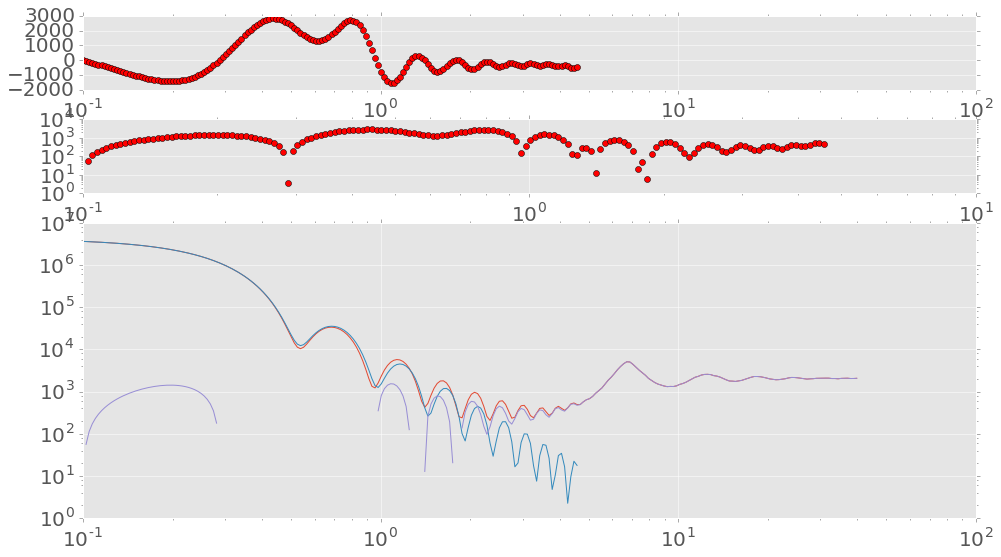

In [266]:
exp_avg = getAverage(exp_I[800:])
res = doFit(exp_Q,avg,cut=90)
myResids(res,exp_Q,avg)


(100, 1000000)

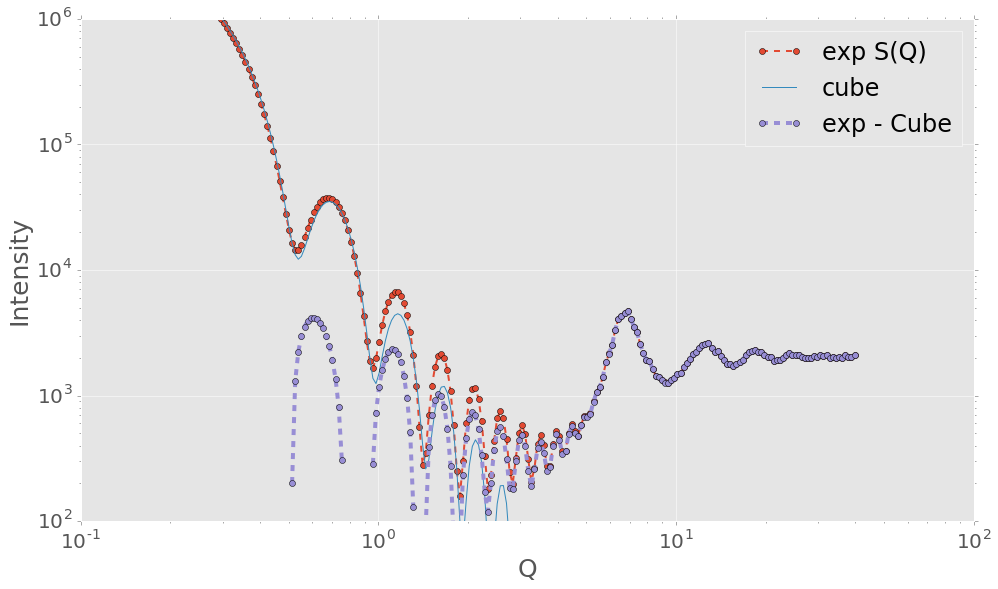

In [271]:
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
plt.loglog(debye_Q,exp_avg,'o--',label='exp S(Q)',lw=2)
# plt.plot(q,sq/sq[-1],'o--',label='g(r) -> S(Q)',lw=2)
# plt.ylim([-50,70])
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.legend()
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
plt.loglog(exp_Q,cubeI*exp_avg[0]/cubeI[0],label='cube')
plt.plot(exp_Q,exp_avg-cubeI*exp_avg[0]/cubeI[0],'o--',lw=4,label='exp - Cube')
plt.legend()
plt.ylim([10**2,10**6])

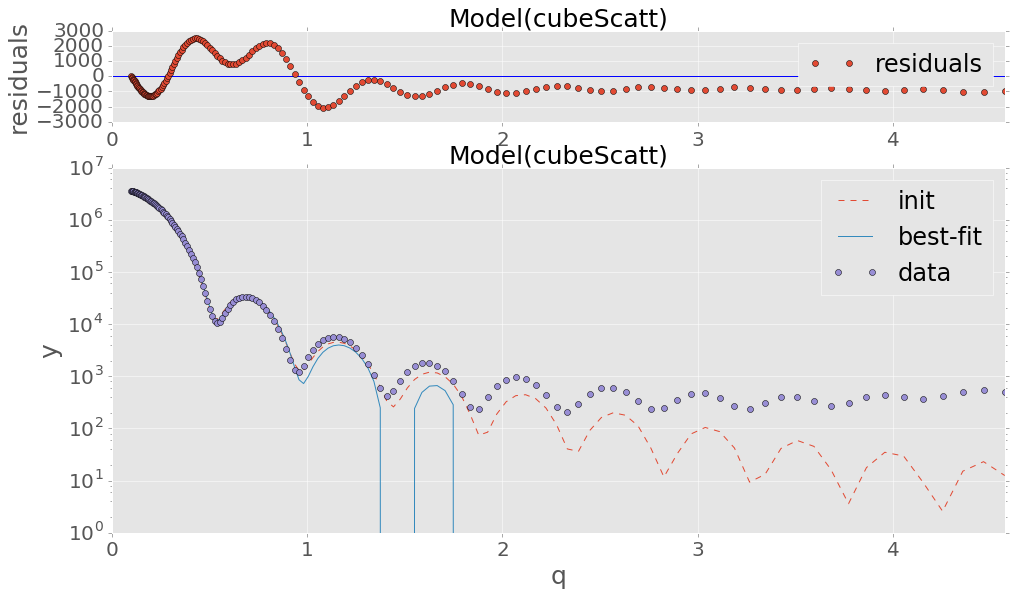

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 160
    # variables        = 2
    chi-square         = 239193865.712
    reduced chi-square = 1513885.226
    Akaike info crit   = 2280.830
    Bayesian info crit = 2286.981
[[Variables]]
    box:   13.2818924 +/- 0.001126 (0.01%) (init= 13.4)
    bkg:  -6.86921217 +/- 1.619489 (23.58%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(box, bkg)                  =  0.383 



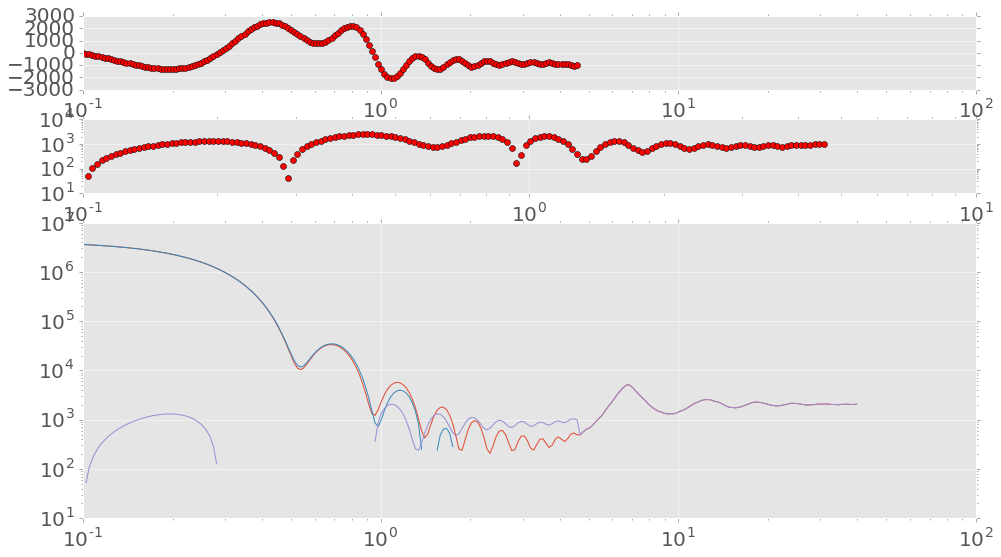

In [272]:
def doFit(Q,data,cut=80,func=None,pars=None):

    from lmfit import Model, Parameters
    from warnings import warn
    if func is None:
        def cubeScatt(q, box = 13.4,bkg=0):
            from _cube import lib
            I_cube = np.zeros_like(q)

            for i,Q in enumerate(q):
                I_cube[i] = lib.Iq(Q,10,0,box,box,box)+bkg
            return I_cube*data[0]/I_cube[0]
        func = cubeScatt
        pars = Parameters()
        pars.add('box',value=13.4)
        #pars.add('bkg',value=min(data[:-cut]))
        pars.add('bkg',value=0,vary=True)

    mod = Model(func)
    if pars is None:
        warn("parameters may be bad guess")
        plt.show()
        pars = mod.make_params()
    res = mod.fit(data[:-cut],pars,q=Q[:-cut])#,weights=(1./data[:-cut])*10**4)
    fig = res.plot()
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_xlim([0,max(Q[:-cut])])
#     ax.set_ylim([10**1,10**7])
    plt.show()
    print(res.fit_report())
    return res
exp_avg = getAverage(exp_I[800:])
res = doFit(exp_Q,avg,cut=90)
myResids(res,exp_Q,avg)


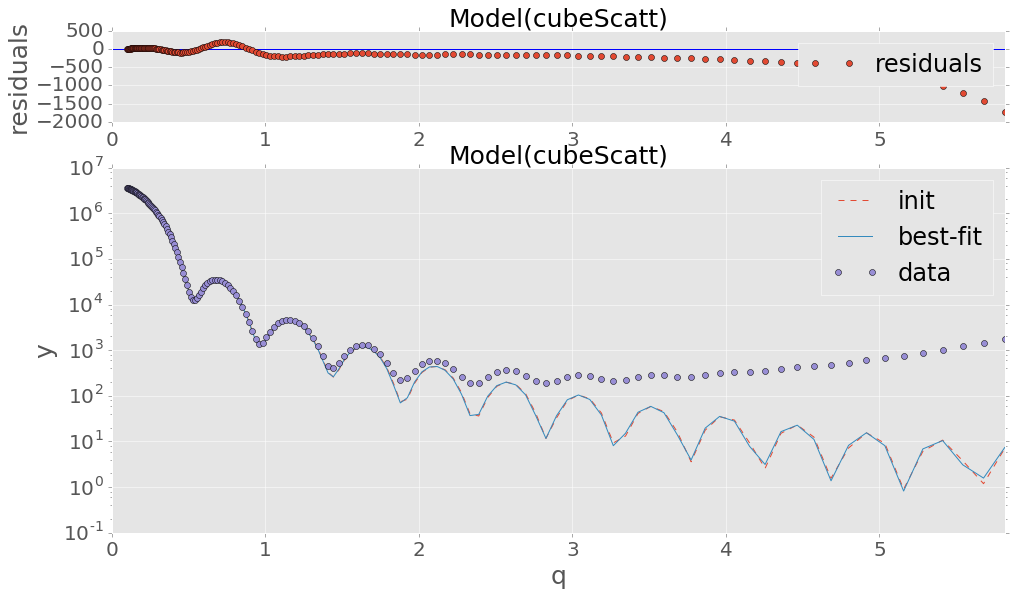

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 170
    # variables        = 1
    chi-square         = 13309596.896
    reduced chi-square = 78755.011
    Akaike info crit   = 1918.597
    Bayesian info crit = 1921.732
[[Variables]]
    box:   13.4288681 +/- 0.000241 (0.00%) (init= 13.4)
    bkg:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



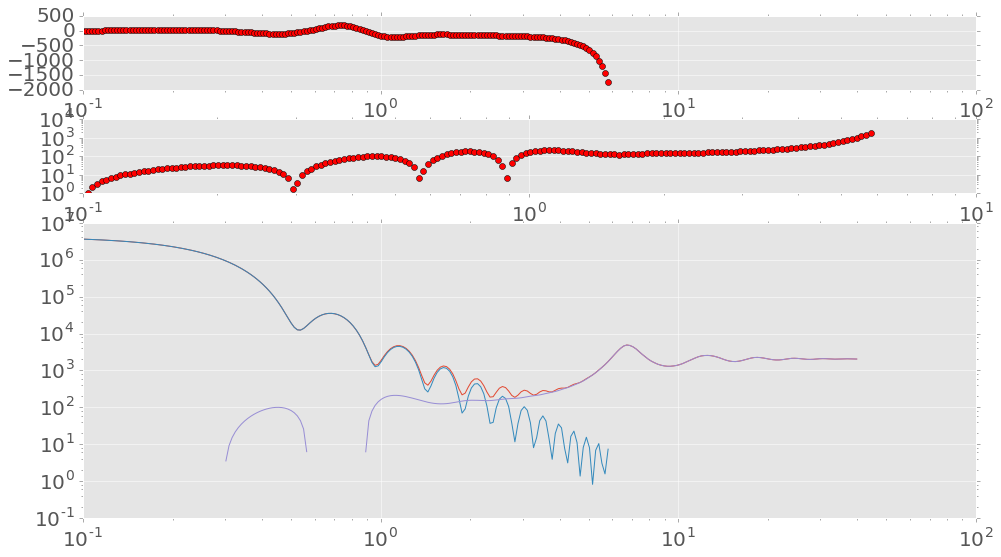

In [256]:
debye_avg = getAverage(debye_I[800:])
res = doFit(debye_Q,debye_avg)
myResids(res,debye_Q,debye_avg)

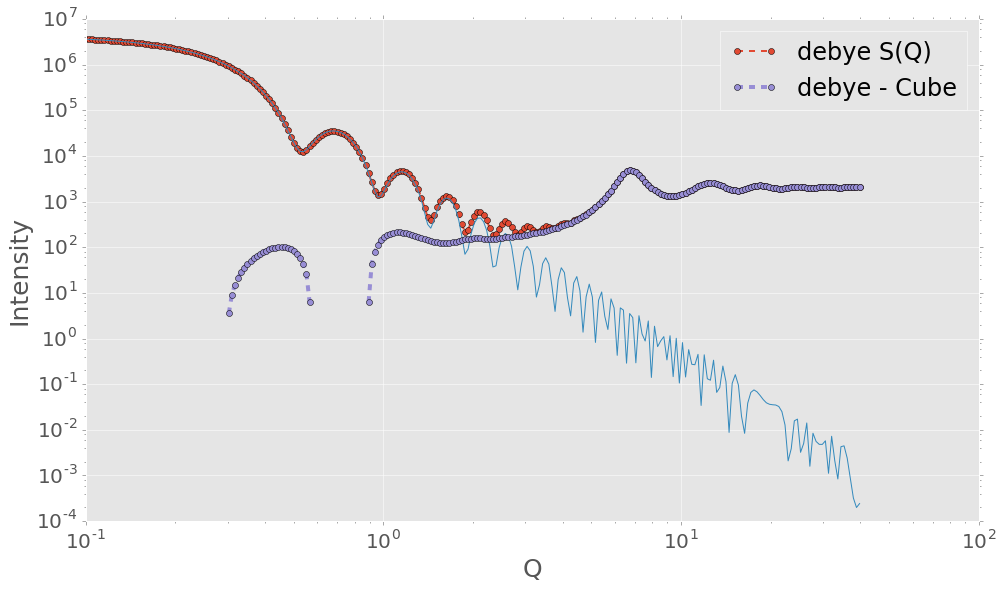

In [265]:
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
plt.loglog(debye_Q,debye_avg,'o--',label='debye S(Q)',lw=2)
# plt.plot(q,sq/sq[-1],'o--',label='g(r) -> S(Q)',lw=2)
# plt.ylim([-50,70])
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.legend()
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
plt.loglog(debye_Q,cubeI*debye_avg[0]/cubeI[0])
plt.plot(exp_Q,debye_avg-cubeI*debye_avg[0]/cubeI[0],'o--',lw=4,label='debye - Cube')
plt.legend()
# plt.ylim([10**2,10**6])

(0, 4)

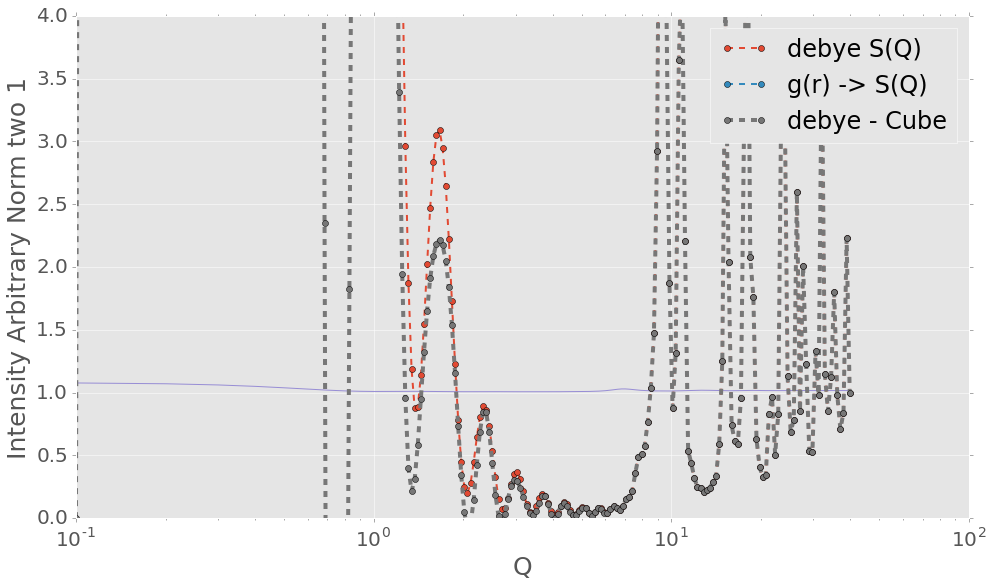

In [347]:
def normINF(x):
    return x/x[-1]
q = np.load('Data/fourierQ.npy')
sq = np.load('Data/fourierSQ.npy')
plt.semilogx(debye_Q,normINF(debye_avg),'o--',label='debye S(Q)',lw=2)

plt.ylim([-50,70])
plt.ylabel('Intensity Arbitrary Norm two 1')
plt.xlabel('Q')
plt.legend()
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
dbyCub = normINF(debye_avg-cubeI*debye_avg[0]/cubeI[0])
pltt = sq*max(dbyCub)/max(sq[15:])
plt.plot(q,pltt,'o--',label='g(r) -> S(Q)',lw=2)
plt.plot(q,sq/(sq[-1]+60)+1)


plt.plot(exp_Q,dbyCub,'o--',lw=4,label='debye - Cube')
plt.legend()
plt.ylim([0,4])

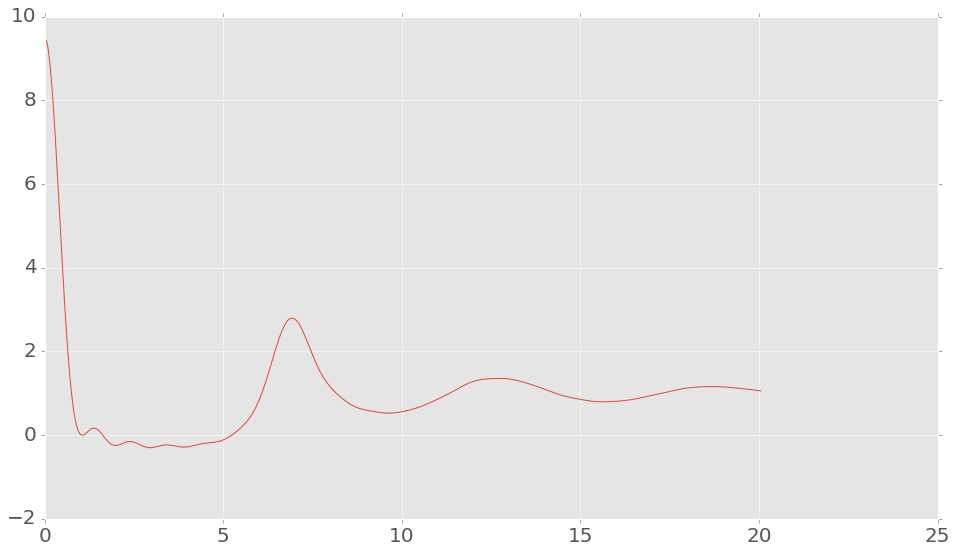

In [304]:
plt.plot(q,sq/(sq[-1]+60)+1)

998


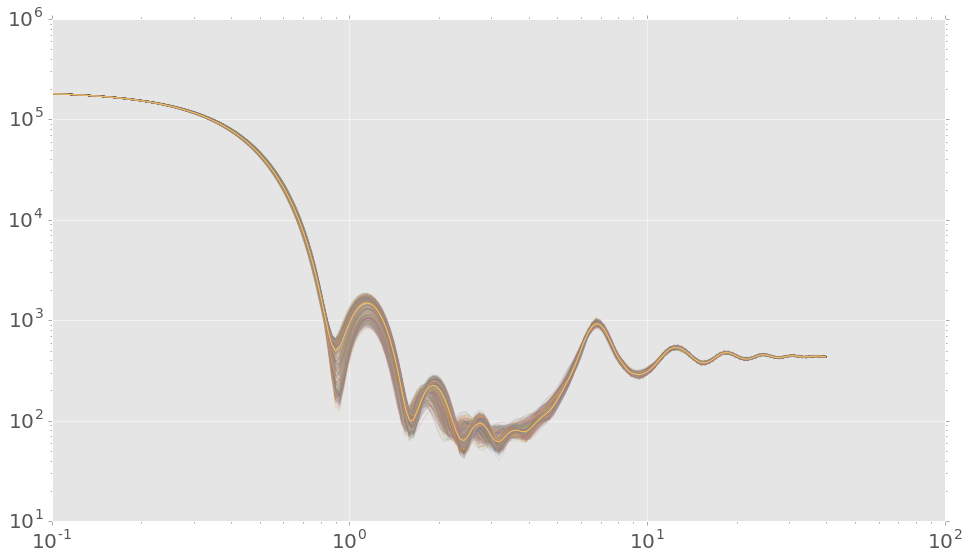

In [351]:
q = np.load('/home/data/Outputs/2016-07-22_18-43/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-43/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I))
print(len(I))

999


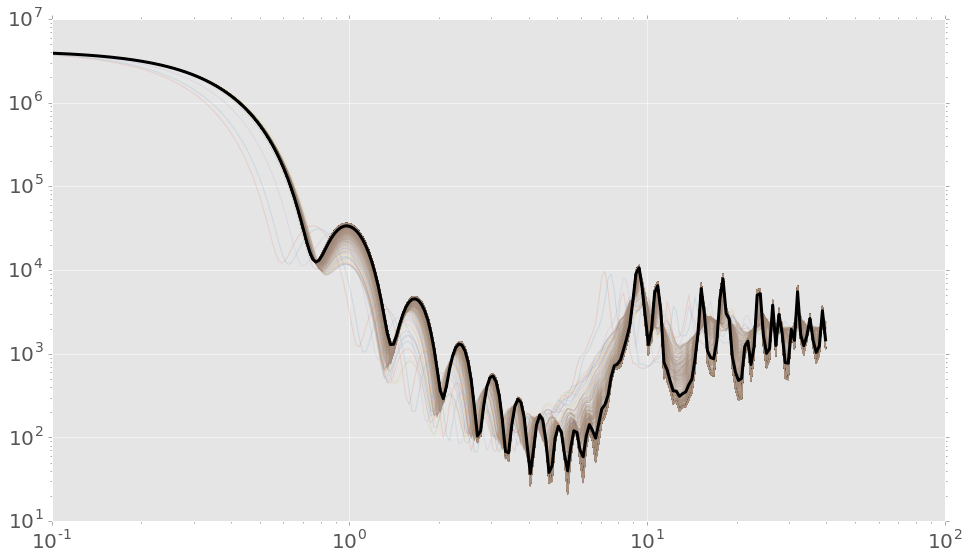

In [394]:
# High Pressure
q = np.load('/home/data/Outputs/2016-07-22_16-43/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_16-43/outPutI-Q250.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I),'k-',lw=3)
print(len(I))

98


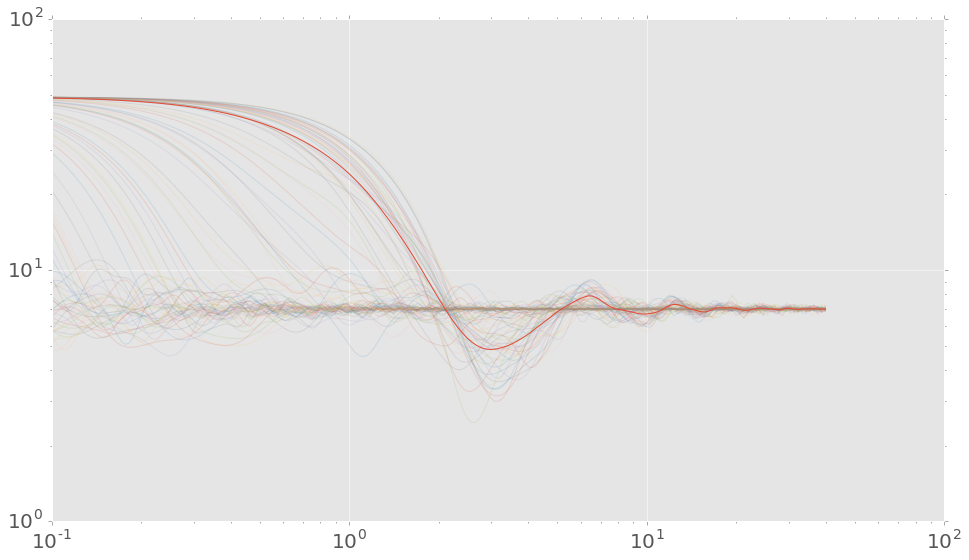

In [376]:
# low Pressure
q = np.load('/home/data/Outputs/2016-07-22_17-40/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_17-40/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I[:-60]))
print(len(I))

697


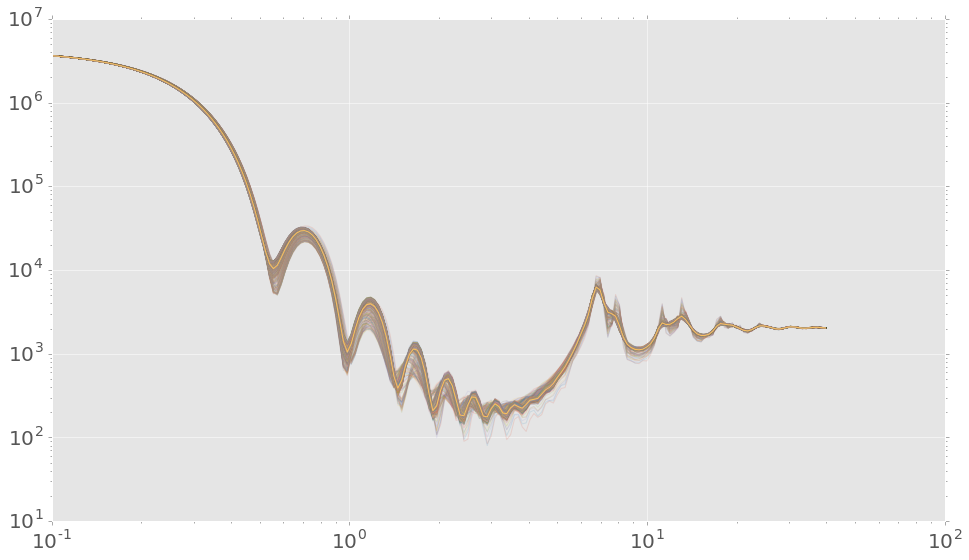

In [377]:
# p0.9
q = np.load('/home/data/Outputs/2016-07-22_17-58/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_17-58/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I[:-60]))
print(len(I))

710


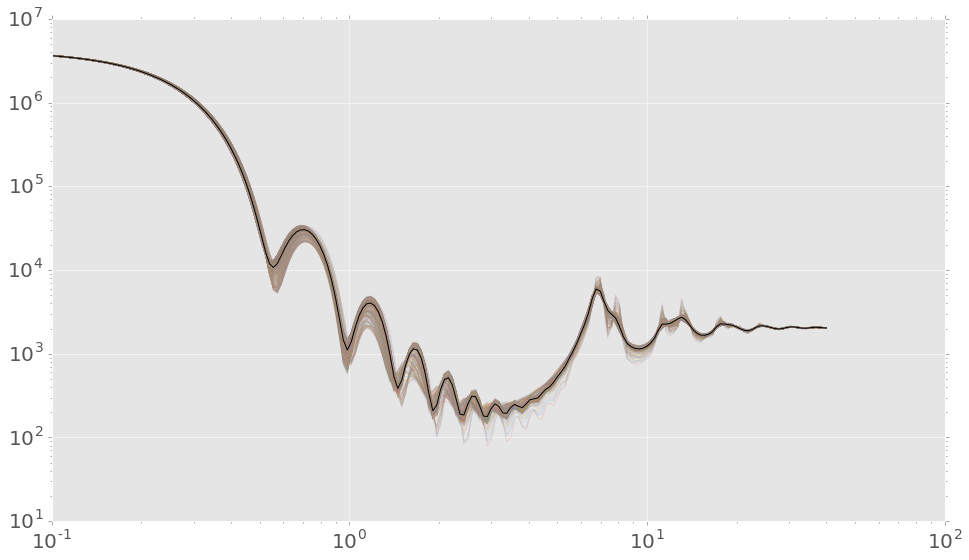

In [379]:
# p1
q = np.load('/home/data/Outputs/2016-07-22_18-16/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-16/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I[:-60]),'k-')
print(len(I))

99998


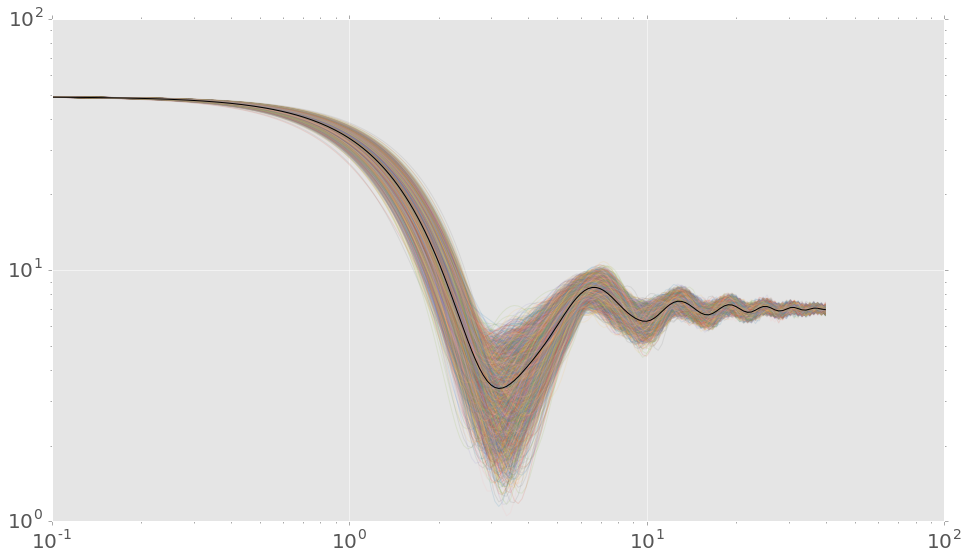

In [387]:
# 2A
#So many frames here. Only using last 5000
q = np.load('/home/data/Outputs/2016-07-22_18-41/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-41/outPutI-Q200.npy')
for i in I[95000:]:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I[95000:]),'k-')
print(len(I))

998


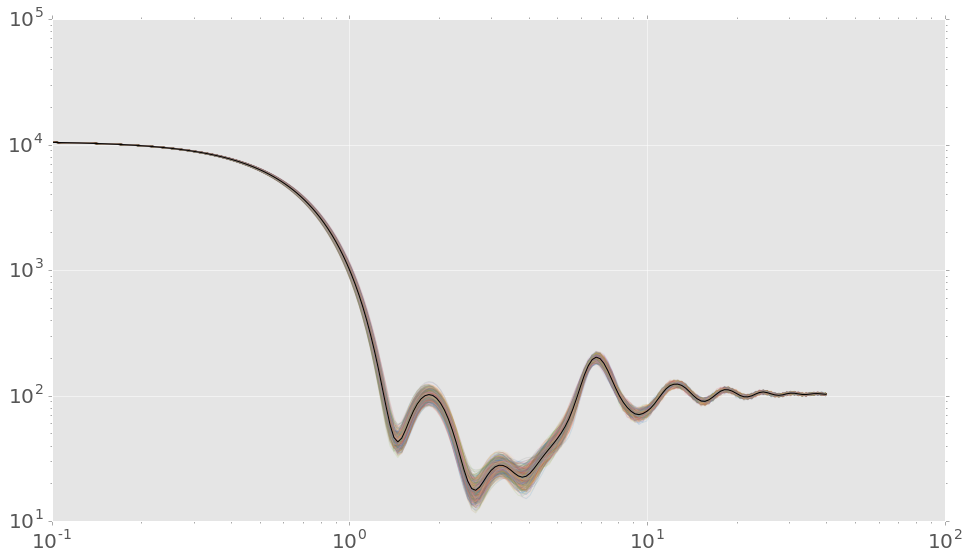

In [389]:
# 5A
#So many frames here. Only using last 5000
q = np.load('/home/data/Outputs/2016-07-22_18-42/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-42/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I),'k-')
print(len(I))

998


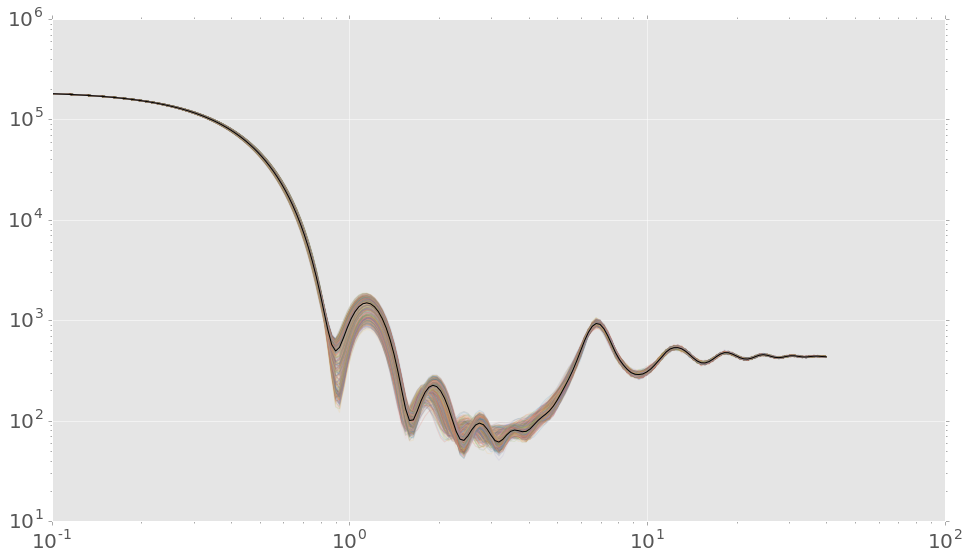

In [391]:
# 8A
#So many frames here. Only using last 5000
q = np.load('/home/data/Outputs/2016-07-22_18-43/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-43/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I),'k-')
print(len(I))

998


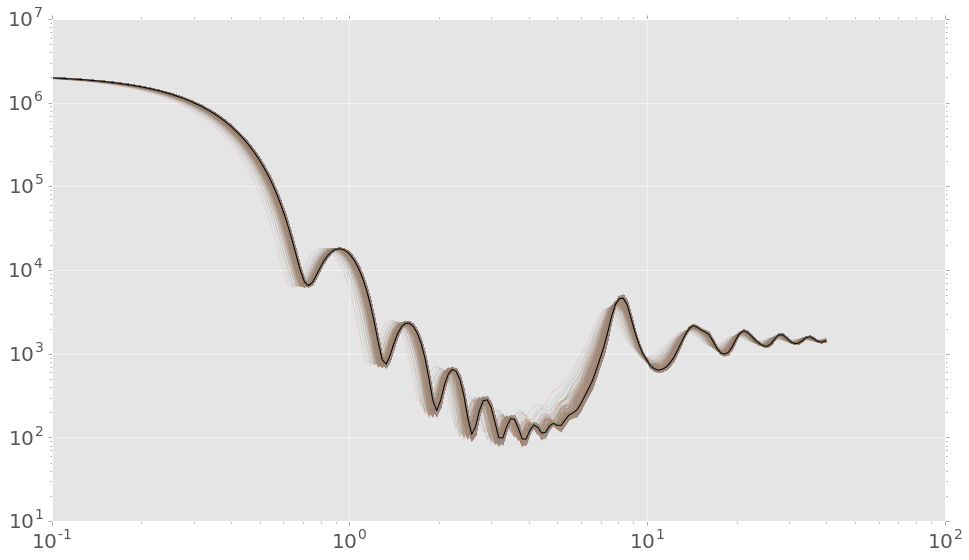

In [392]:
# 12A
#So many frames here. Only using last 5000
q = np.load('/home/data/Outputs/2016-07-22_18-51/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_18-51/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I),'k-')
print(len(I))

693


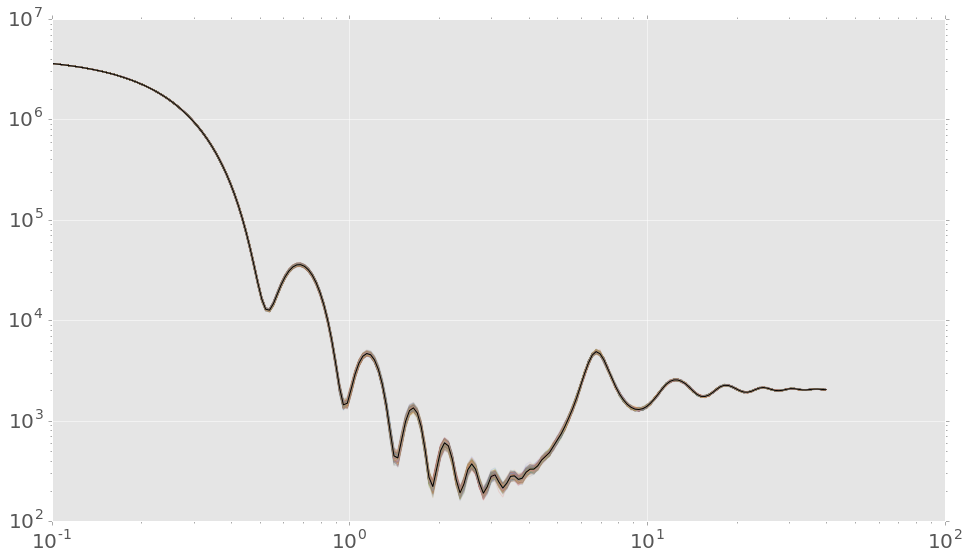

In [393]:
# 13.4A
#So many frames here. Only using last 5000
q = np.load('/home/data/Outputs/2016-07-22_19-08/Q_list.npy')
I = np.load('/home/data/Outputs/2016-07-22_19-08/outPutI-Q200.npy')
for i in I:
    plt.loglog(q,i,alpha=.15)
plt.loglog(q,getAverage(I),'k-')
print(len(I))

/home/ianhi/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(-10, 10)

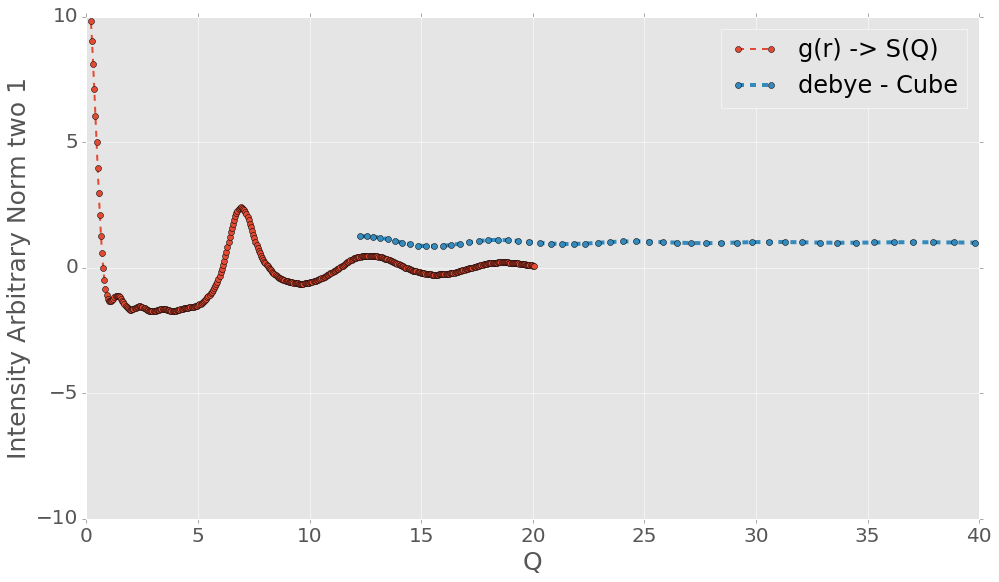

In [291]:
def normINF(x):
    return x/x[-1]

# plt.semilogx(debye_Q,normINF(debye_avg),'o--',label='debye S(Q)',lw=2)

plt.ylabel('Intensity Arbitrary Norm two 1')
plt.xlabel('Q')
plt.legend()
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)
dbyCub = normINF(debye_avg-cubeI*debye_avg[0]/cubeI[0])
pltt = sq*max(dbyCub)/max(sq[15:])
plt.plot(q,pltt,'o--',label='g(r) -> S(Q)',lw=2)

cut=200
plt.plot(exp_Q[cut:],dbyCub[cut:],'o--',lw=4,label='debye - Cube')
plt.legend()
plt.ylim([-10,10])

(100, 1000000)

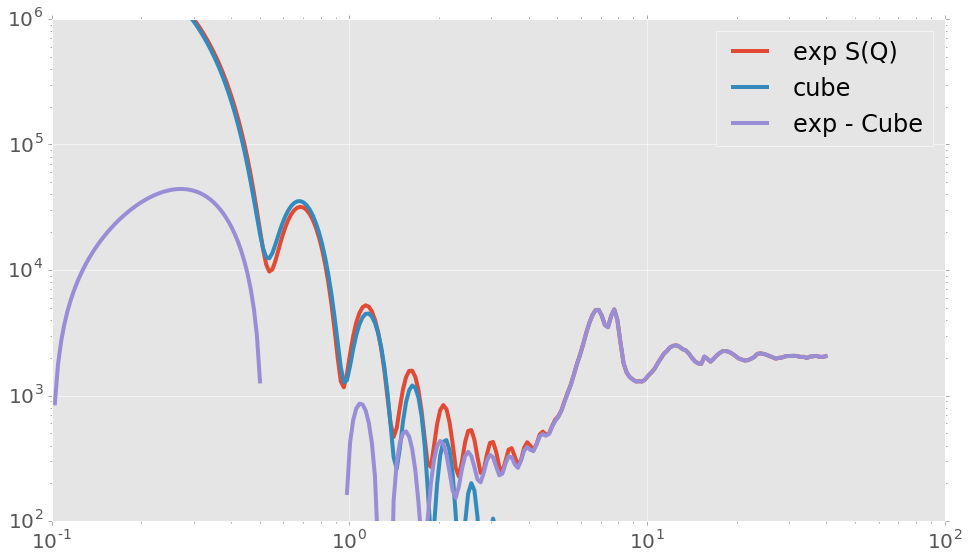

In [229]:
cubeI = cubeScatt(exp_Q,box=13.42,bkg=0)
plt.loglog(exp_Q,exp_avg,label='exp S(Q)',lw=4)
plt.loglog(exp_Q,cubeI*exp_avg[0]/cubeI[0],label='cube',lw=4)
plt.loglog(exp_Q,exp_avg-cubeI*exp_avg[0]/cubeI[0],lw=4,label='exp - Cube')
plt.legend()
plt.ylim([10**2,10**6])

In [ ]:
cubeI = cubeScatt(exp_Q,box=13.42,bkg=0)
plt.loglog(exp_Q,debye_avg,label='debye S(Q)',lw=4)
plt.loglog(exp_Q,cubeI*debye_avg[0]/cubeI[0],label='cube',lw=4)
plt.loglog(exp_Q,debye_avg-cubeI*debye_avg[0]/cubeI[0],lw=4,label='debye - Cube')
plt.legend()
plt.ylim([10**2,10**6])

In [78]:
fig = plt.figure(figsize=(12,6))
cubeI = cubeScatt(exp_Q,box=13.42,bkg=0)
plt.plot(exp_Q,debye_avg)
plt.plot(exp_Q,cubeI*debye_avg[0]/cubeI[0])
plt.plot(exp_Q,debye_avg-cubeI*debye_avg[0]/cubeI[0],lw=4)
from bokeh import mpl
from bokeh.plotting import show,output_notebook
import bokeh
output_notebook()
show(mpl.to_bokeh())

Session output file 'Unnamed.html' already exists, will be overwritten.


# Smaller Cell

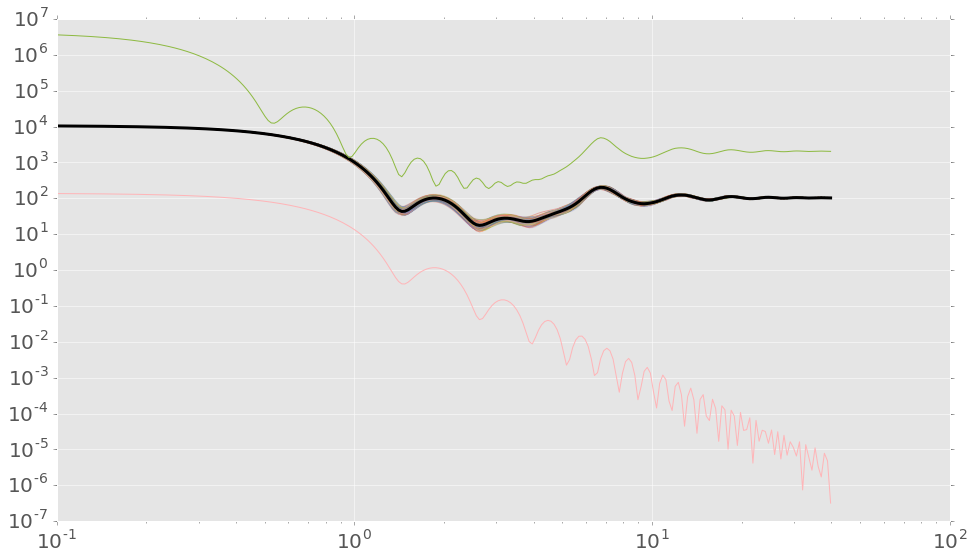

In [79]:
shrunkDBY_q = np.load('/home/data/Outputs/2016-07-21_10-35/Q_list.npy')
shrunkDBY_I = np.load('/home/data/Outputs/2016-07-21_10-35/outPutI-Q250.npy')

for i in shrunkDBY_I:
    plt.loglog(shrunkDBY_q,i,alpha=.4)
shrunkDBY_avg = getAverage(shrunkDBY_I)
plt.loglog(shrunkDBY_q,shrunkDBY_avg,'-k',lw=3)
plt.loglog(debye_Q,debye_avg)
cube5 = cubeScatt(shrunkDBY_q,box=4.9)
plt.loglog(debye_Q,cube5)

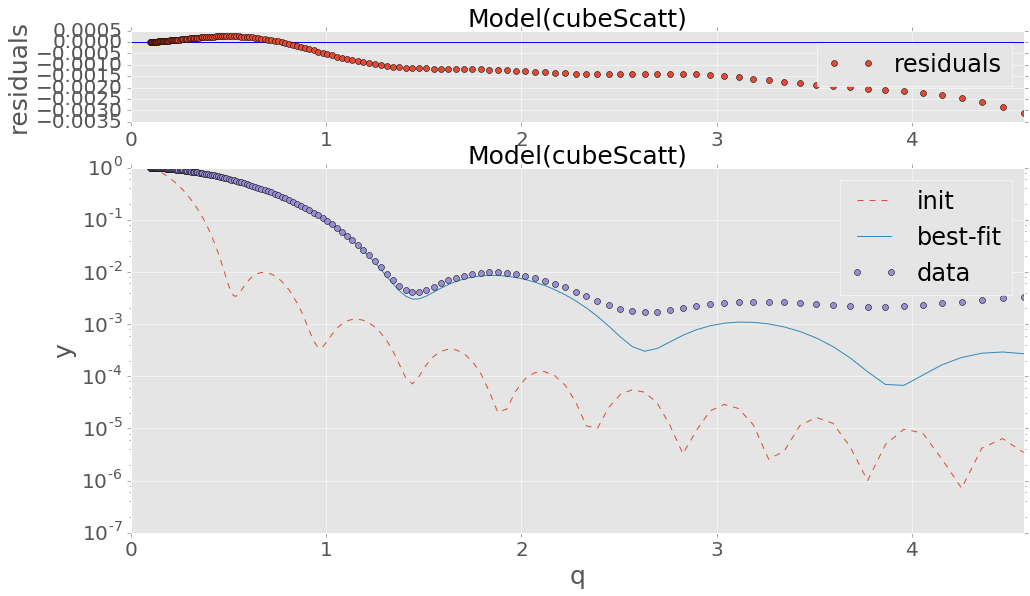

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 160
    # variables        = 1
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -2219.712
    Bayesian info crit = -2216.636
[[Variables]]
    box:   4.91879672 +/- 0.001019 (0.02%) (init= 13.4)
    bkg:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



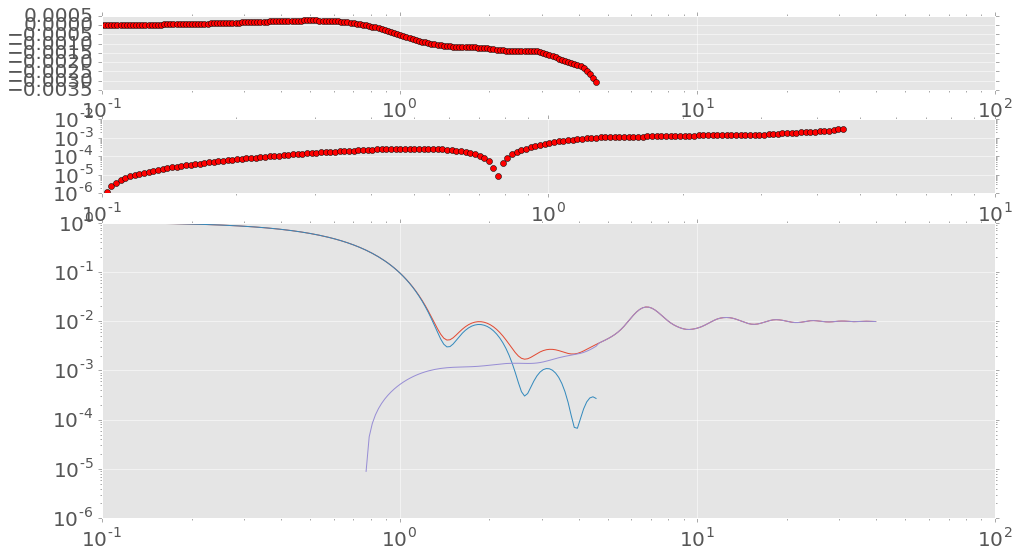

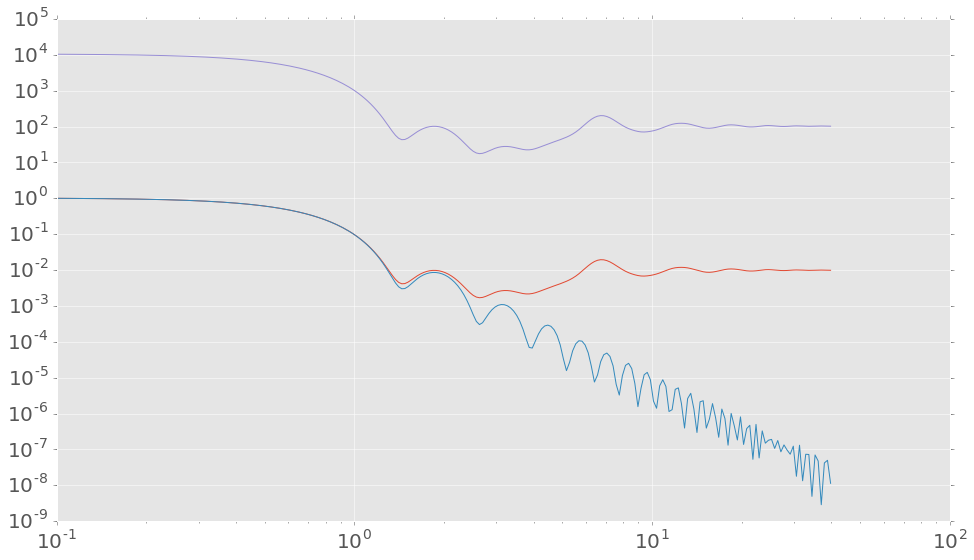

In [233]:
def norm(x):
    return x/max(x)
res = doFit(shrunkDBY_q,norm(shrunkDBY_avg),cut=90)
myResids(res,shrunkDBY_q,norm(shrunkDBY_avg))


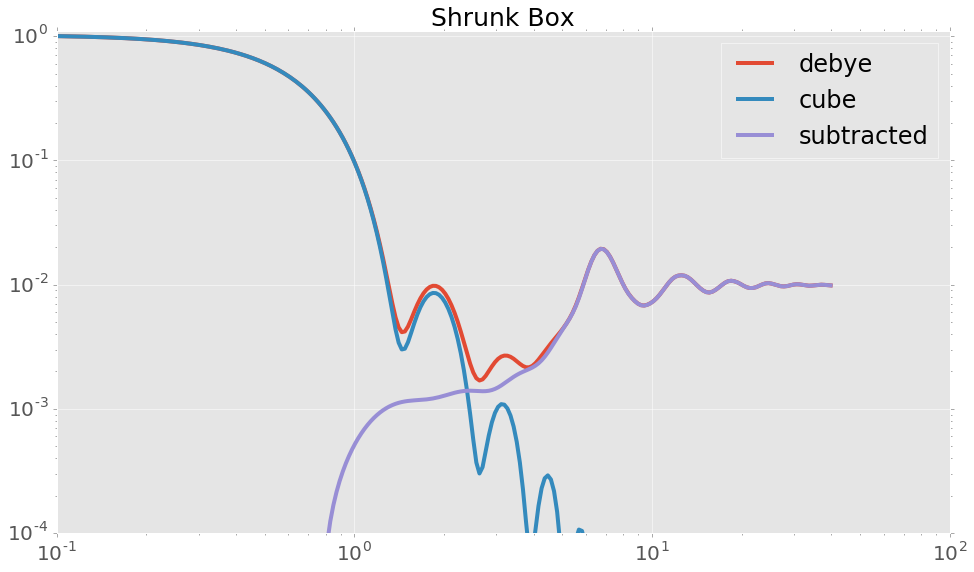

In [241]:
plt.figure()
plt.loglog(shrunkDBY_q,norm(shrunkDBY_avg),lw=4,label='debye')
cubeI = norm(cubeScatt(shrunkDBY_q,res.best_values['box']))
plt.loglog(shrunkDBY_q,cubeI,label='cube',lw=4)
plt.loglog(shrunkDBY_q,norm(shrunkDBY_avg)-cubeI,lw=4,label='subtracted')
q = np.load('Data/fourierQ.npy')
sq = np.load('Data/fourierSQ.npy')
plt.plot(q,sq/np.mean(sq[:-20][sq[:-20]>0]),'o--',label='g(r) -> S(Q)',lw=2)
plt.ylim([10**-4,1.1])
plt.title('Shrunk Box')
plt.legend()

# Plot Fourier Transform

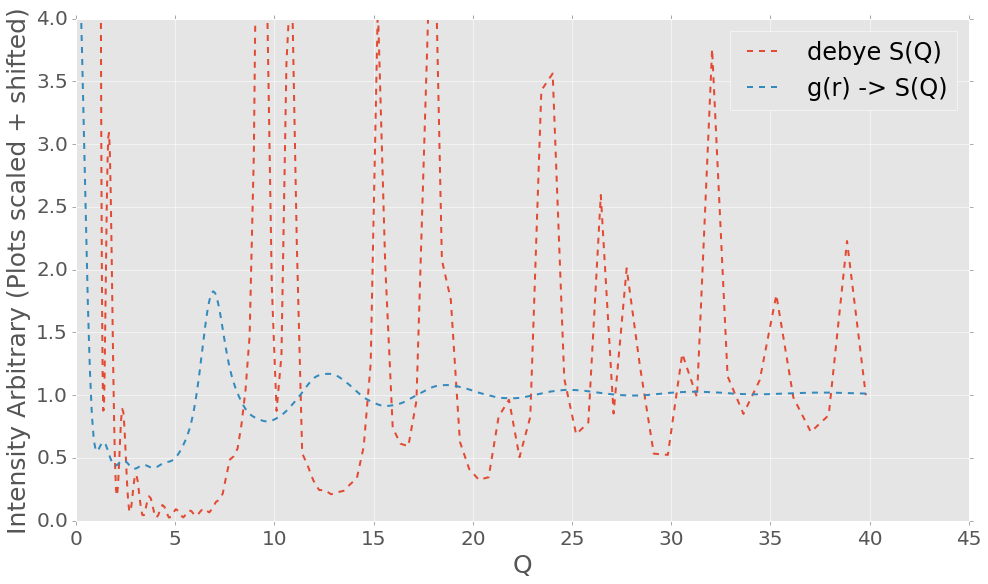

In [348]:
q = np.load('Data/fourierQ.npy')
sq = np.load('Data/fourierSQ.npy')
plt.plot(debye_Q,debye_avg/debye_avg[-1],'--',label='debye S(Q)',lw=2)
plt.plot(q,sq/np.mean(sq[:-20][sq[:-20]>0]),'--',label='g(r) -> S(Q)',lw=2)
plt.ylim([0,4])
plt.ylabel('Intensity Arbitrary (Plots scaled + shifted)')
plt.xlabel('Q')
plt.legend()
plt.show()

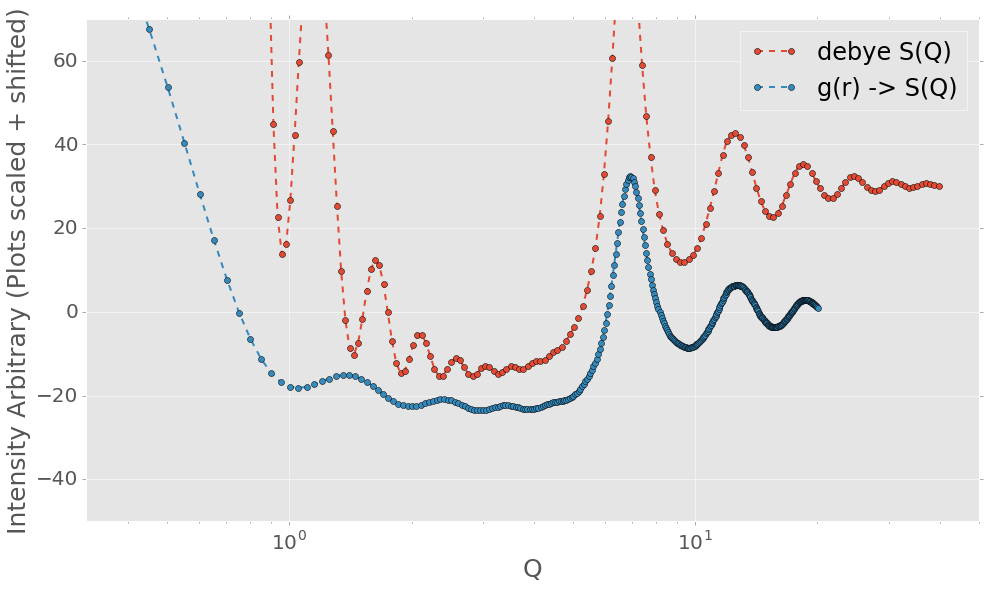

In [216]:
q = np.load('Data/fourierQ.npy')
sq = np.load('Data/fourierSQ.npy')
plt.semilogx(debye_Q,debye_avg/debye_avg[-1]*50-20,'o--',label='debye S(Q)',lw=2)
plt.plot(q,sq/sq[-1],'o--',label='g(r) -> S(Q)',lw=2)
plt.ylim([-50,70])
plt.xlim([10**-.5,10**1.7])
plt.ylabel('Intensity Arbitrary (Plots scaled + shifted)')
plt.xlabel('Q')
plt.legend()
plt.show()

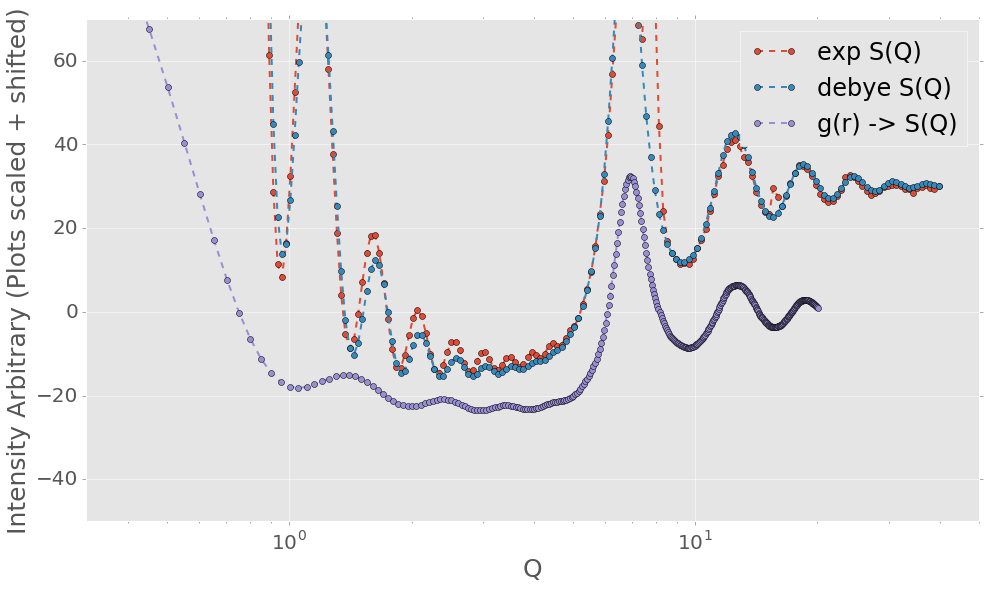

In [219]:
q = np.load('Data/fourierQ.npy')
sq = np.load('Data/fourierSQ.npy')
plt.semilogx(debye_Q,exp_avg/exp_avg[-1]*50-20,'o--',label='exp S(Q)',lw=2)
plt.semilogx(debye_Q,debye_avg/debye_avg[-1]*50-20,'o--',label='debye S(Q)',lw=2)

plt.plot(q,sq/sq[-1],'o--',label='g(r) -> S(Q)',lw=2)
plt.ylim([-50,70])
plt.xlim([10**-.5,10**1.7])
plt.ylabel('Intensity Arbitrary (Plots scaled + shifted)')
plt.xlabel('Q')
plt.legend()
plt.show()

(1, 10020)

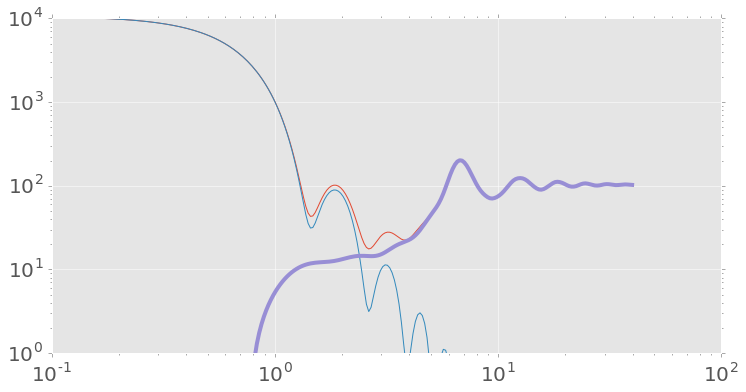

In [222]:
fig = plt.figure(figsize=(12,6))
cubeI = cubeScatt(exp_Q,box=res.best_values['box'],bkg=0)

plt.loglog(shrunkDBY_q,shrunkDBY_avg)
plt.plot(shrunkDBY_q,cubeI*shrunkDBY_avg[0]/cubeI[0])
plt.plot(shrunkDBY_q,shrunkDBY_avg-cubeI*shrunkDBY_avg[0]/cubeI[0],lw=4)
plt.ylim([10**0,10**4+20])
# show(mpl.to_bokeh())

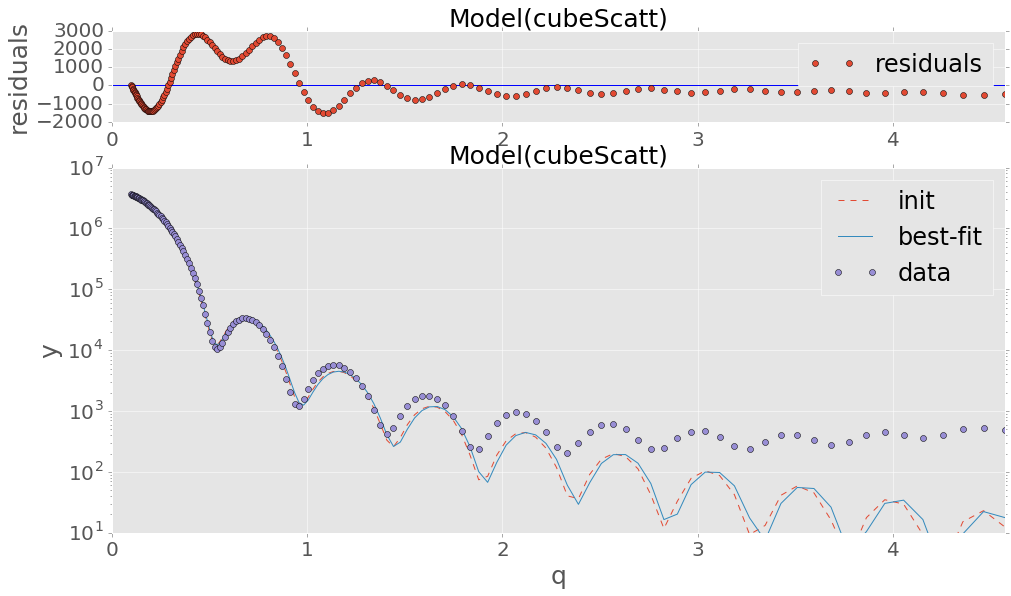

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 160
    # variables        = 1
    chi-square         = 266385818.656
    reduced chi-square = 1675382.507
    Akaike info crit   = 2295.048
    Bayesian info crit = 2298.124
[[Variables]]
    box:   13.2837250 +/- 0.001093 (0.01%) (init= 13.4)
    bkg:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



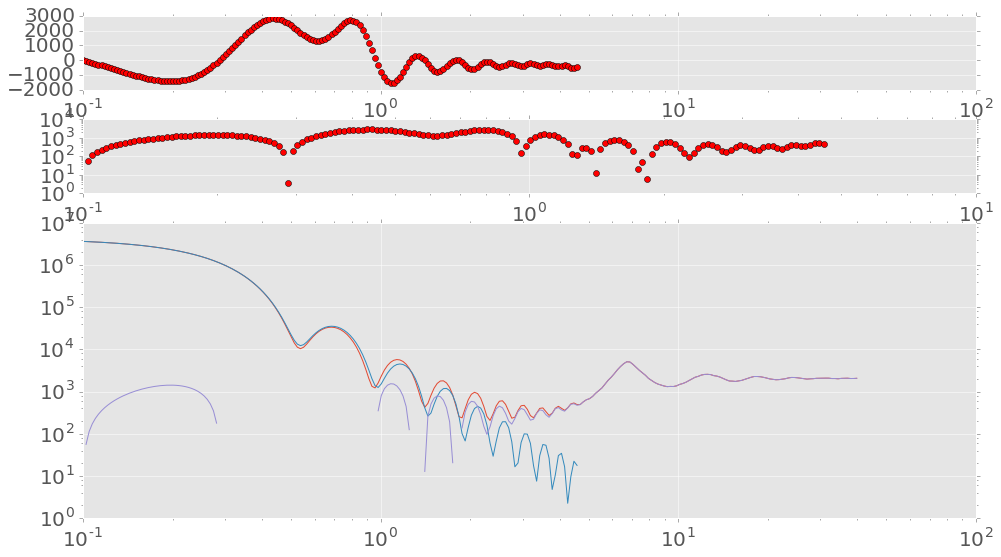

In [18]:
def cubeScatt(q, box = 13.4,bkg=0):
    from _cube import lib
    I_cube = np.zeros_like(q)

    for i,Q in enumerate(q):
        I_cube[i] = lib.Iq(Q,10,0,box,box,box)+bkg
    return I_cube*exp_avg[0]/I_cube[0]
res = doFit(exp_Q,avg,cut=90)
myResids(res,exp_Q,avg)

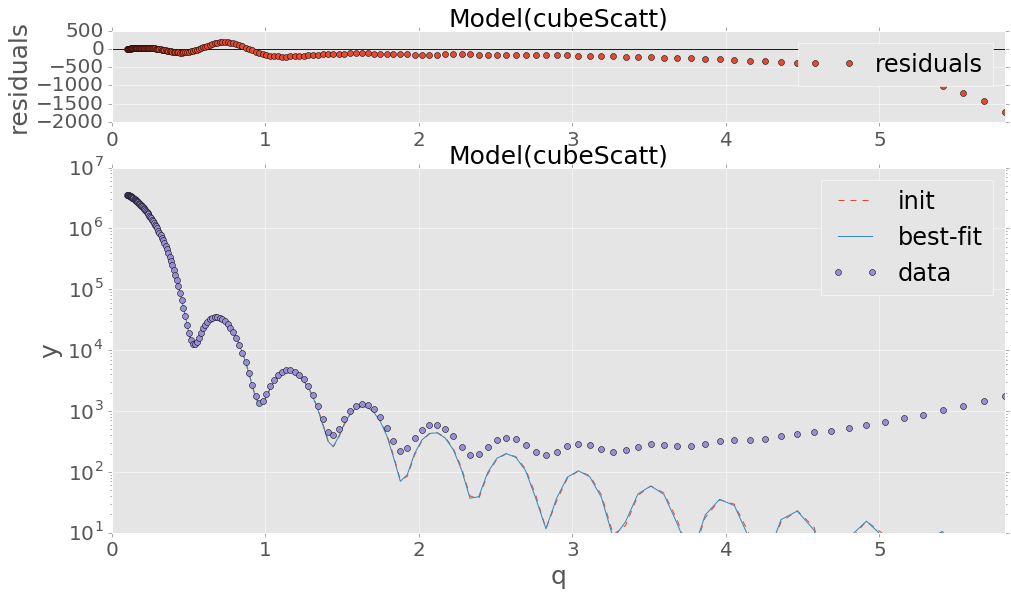

[[Model]]
    Model(cubeScatt)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 170
    # variables        = 1
    chi-square         = 13309596.896
    reduced chi-square = 78755.011
    Akaike info crit   = 1918.597
    Bayesian info crit = 1921.732
[[Variables]]
    box:   13.4288681 +/- 0.000241 (0.00%) (init= 13.4)
    bkg:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



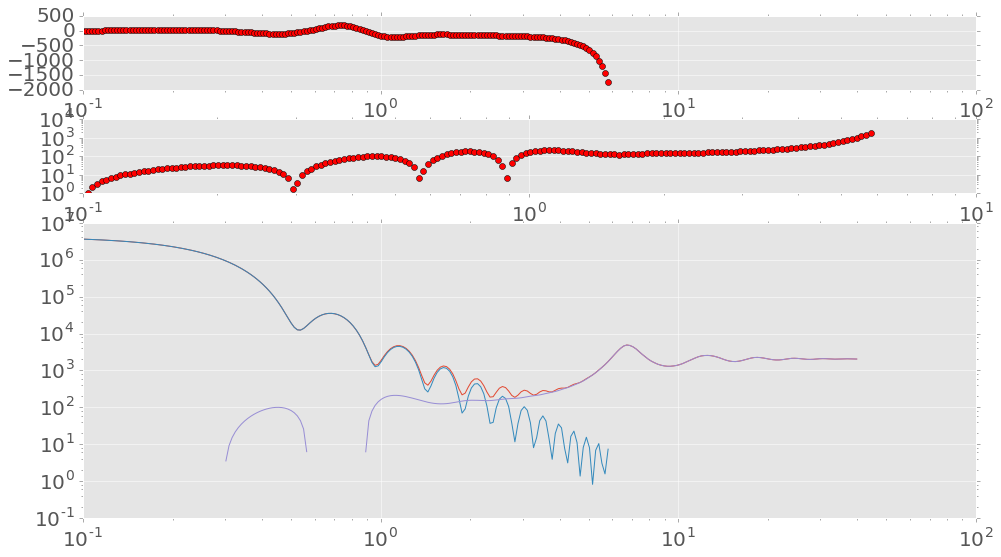

In [19]:
res = doFit(debye_Q,debye_avg)
myResids(res,debye_Q,debye_avg)

# Different Average Slices

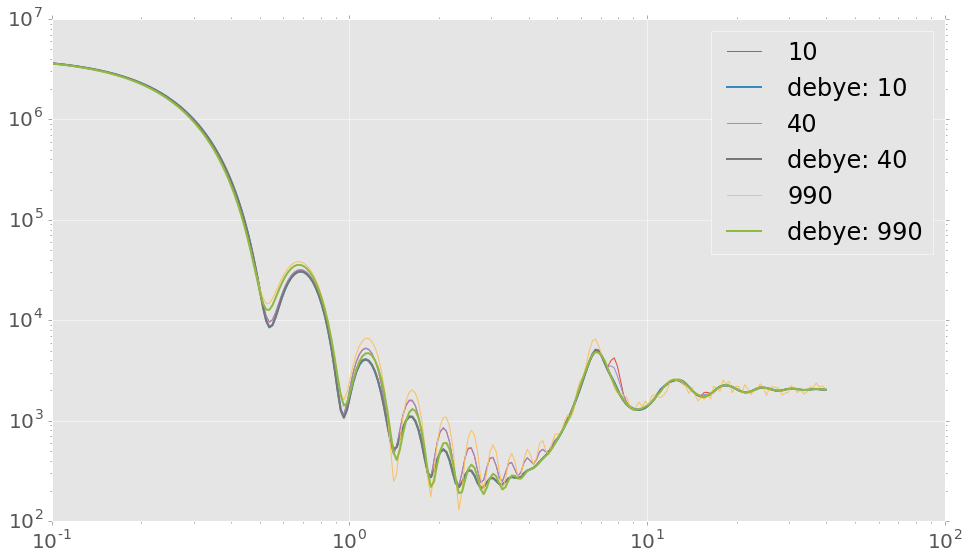

In [20]:
# for ct in [200,400,600]:
for ct in [10,40,990]:
    plt.loglog(exp_Q,getAverage(exp_I[ct:]),label=ct)
    plt.loglog(debye_Q,getAverage(debye_I[ct:]),lw=2,label='debye: '+str(ct))
plt.legend()

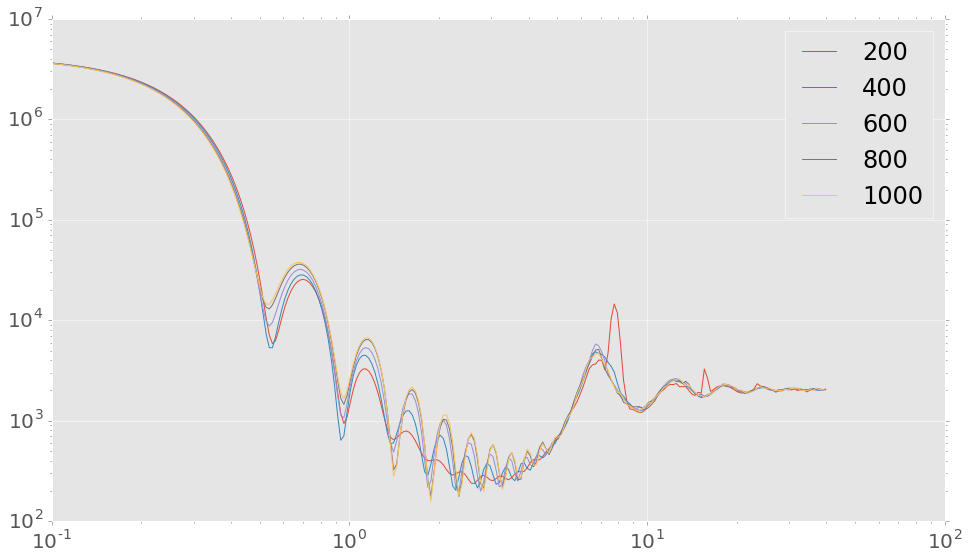

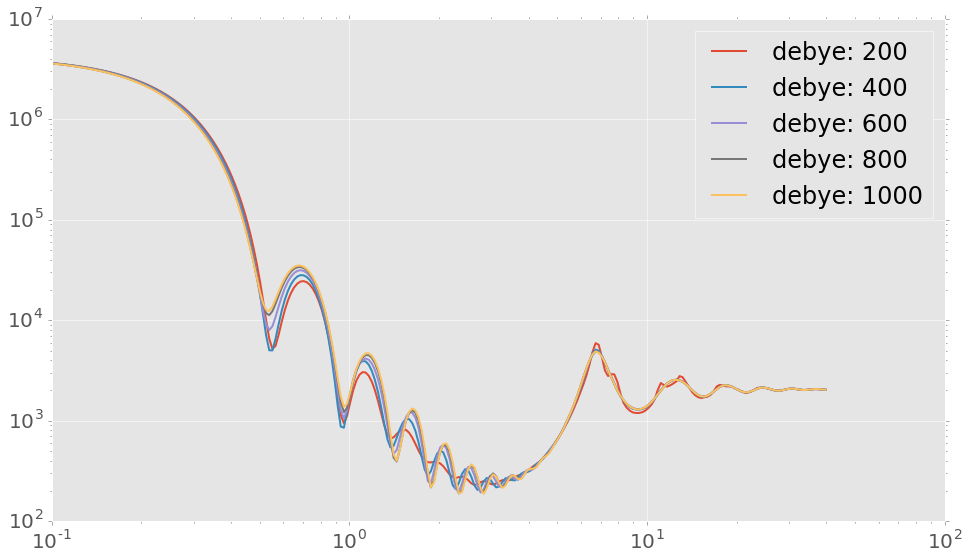

In [21]:
# for ct in [200,400,600]:
frame_ranges = [[0,200], [200, 400], [400, 600], [600, 800], [800, 1000]]
for frame_range in frame_ranges:
    plt.loglog(exp_Q,getAverage(exp_I[frame_range[0]:frame_range[1]]),label=frame_range[1])
plt.legend()
plt.figure()
for frame_range in frame_ranges:
    plt.loglog(debye_Q,getAverage(debye_I[frame_range[0]:frame_range[1]]),lw=2,label='debye: {}'.format(frame_range[1]))
plt.legend()

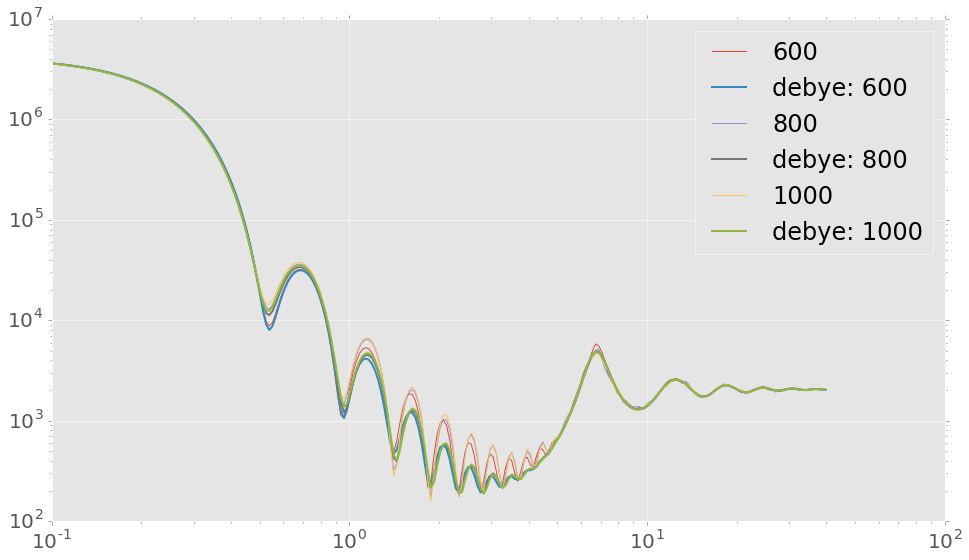

In [22]:
# for ct in [200,400,600]:
frame_ranges = [[400, 600], [600, 800], [800, 1000]]
for frame_range in frame_ranges:
    plt.loglog(exp_Q,getAverage(exp_I[frame_range[0]:frame_range[1]]),label=frame_range[1])
    plt.loglog(debye_Q,getAverage(debye_I[frame_range[0]:frame_range[1]]),lw=2,label='debye: {}'.format(frame_range[1]))
plt.legend()

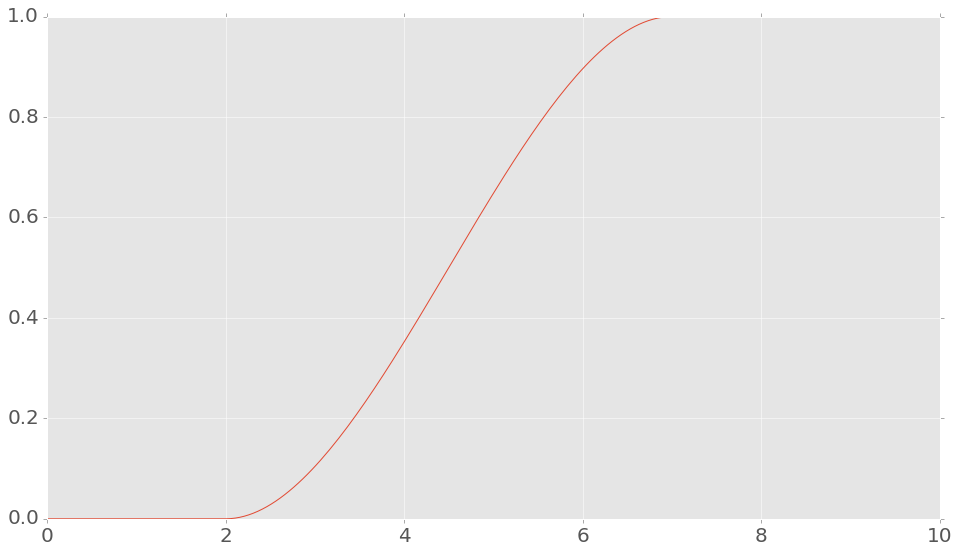

In [178]:
def decay(Q,Qmin,Qmax):
    output=np.zeros_like(Q)

    numer = -(Qmin-Q)**2*(Qmin+2*Q-3*Qmax)
    denom = (Qmax-Qmin)**3
    output = numer/denom
    

    output[Q<Qmin] = 0
    output[Q>Qmax] = 1
    return output
x = np.linspace(0,10,200)
y = decay(x,Qmin=2,Qmax=7)
plt.plot(x,y)
# plt.ylim([-.1,1.1])

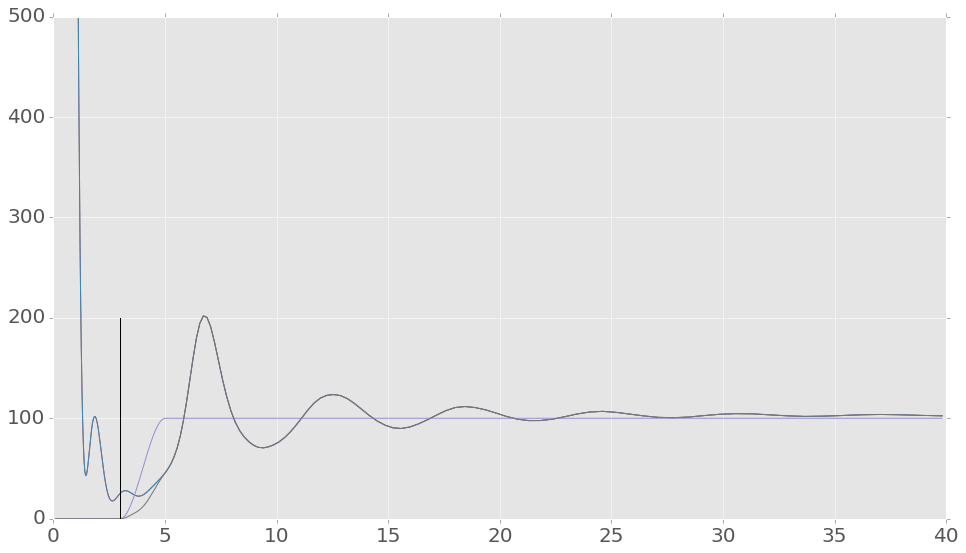

In [182]:
plt.plot(shrunkDBY_q,shrunkDBY_avg)
minV = 3
maxV = 5
plt.plot(shrunkDBY_q,shrunkDBY_avg)
plt.plot(shrunkDBY_q,decay(shrunkDBY_q,minV,maxV)*100)
plt.plot(shrunkDBY_q,shrunkDBY_avg*decay(shrunkDBY_q,minV,maxV))
plt.ylim([-.1,500])
plt.plot((minV,minV), (0, 200), 'k-') 

In [141]:
mol.coor()[-1]

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

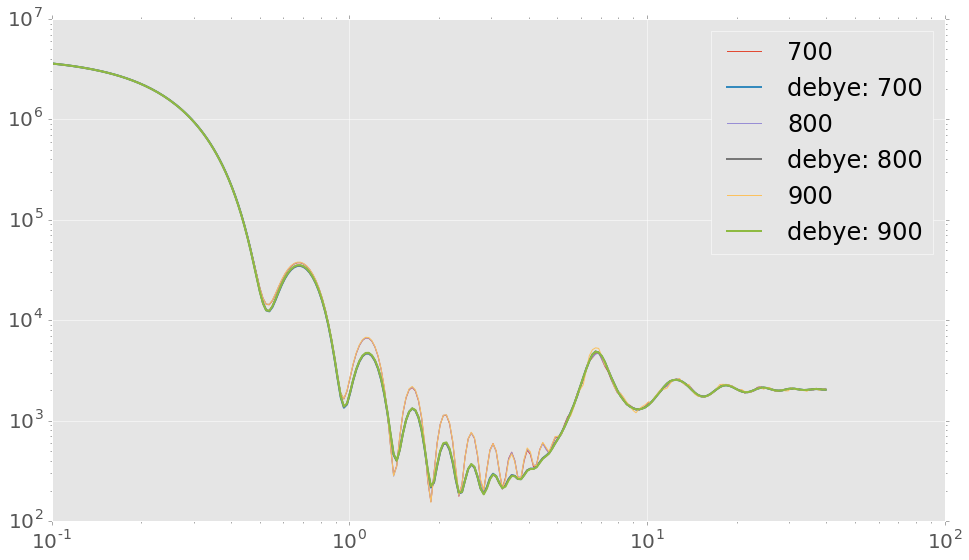

In [23]:
# for ct in [200,400,600]:
frame_ranges = [[700, 1000], [800, 1000], [900, 1000]]
for frame_range in frame_ranges:
    plt.loglog(exp_Q,getAverage(exp_I[frame_range[0]:frame_range[1]]),label=frame_range[0])
    plt.loglog(debye_Q,getAverage(debye_I[frame_range[0]:frame_range[1]]),lw=2,label='debye: {}'.format(frame_range[0]))
plt.legend()

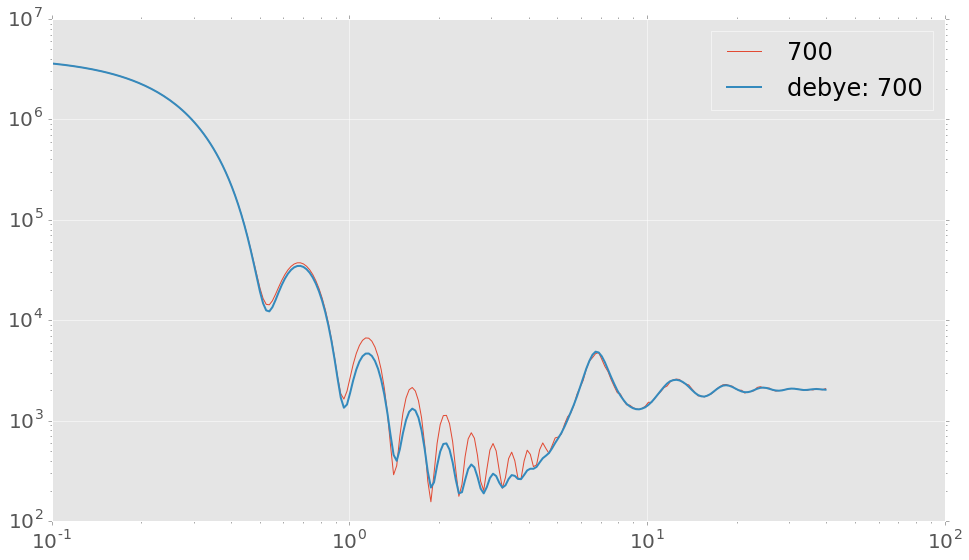

In [24]:
# for ct in [200,400,600]:
frame_ranges = [[700, 1000]]
for frame_range in frame_ranges:
    plt.loglog(exp_Q,getAverage(exp_I[frame_range[0]:frame_range[1]]),label=frame_range[0])
    plt.loglog(debye_Q,getAverage(debye_I[frame_range[0]:frame_range[1]]),lw=2,label='debye: {}'.format(frame_range[0]))
plt.legend()

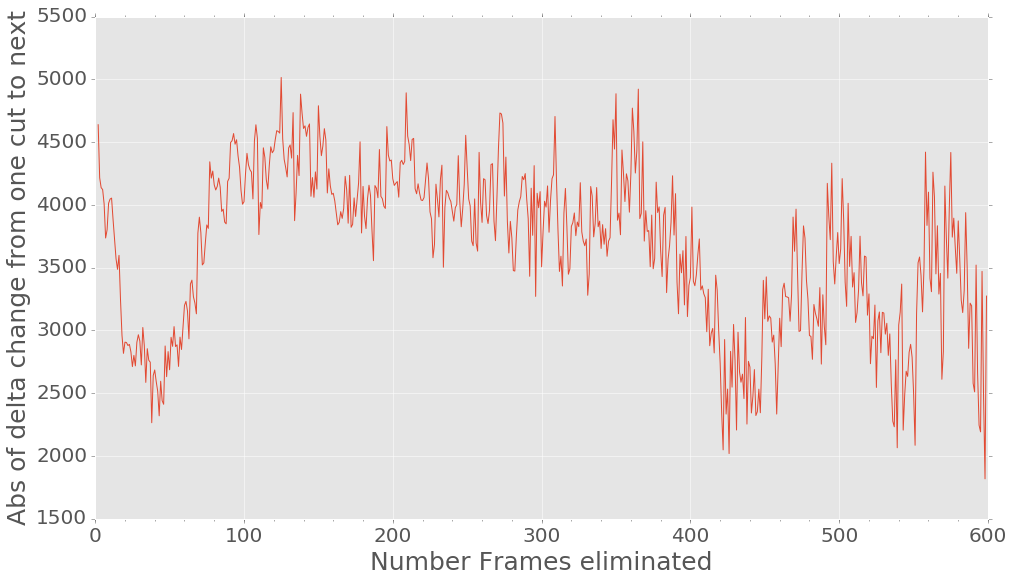

In [25]:

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator = MultipleLocator(20)
delta = []
prev = getAverage(exp_I[1:])
end = 600
for i in xrange(2,end):
    new = getAverage(exp_I[i:])
    delta.append(sum(abs(prev-new)))
    prev = new.copy()
plt.plot(range(2,end),delta)
ax = plt.gca()
ax.xaxis.set_minor_locator(minorLocator)

plt.xlabel('Number Frames eliminated')
plt.ylabel('Abs of delta change from one cut to next')

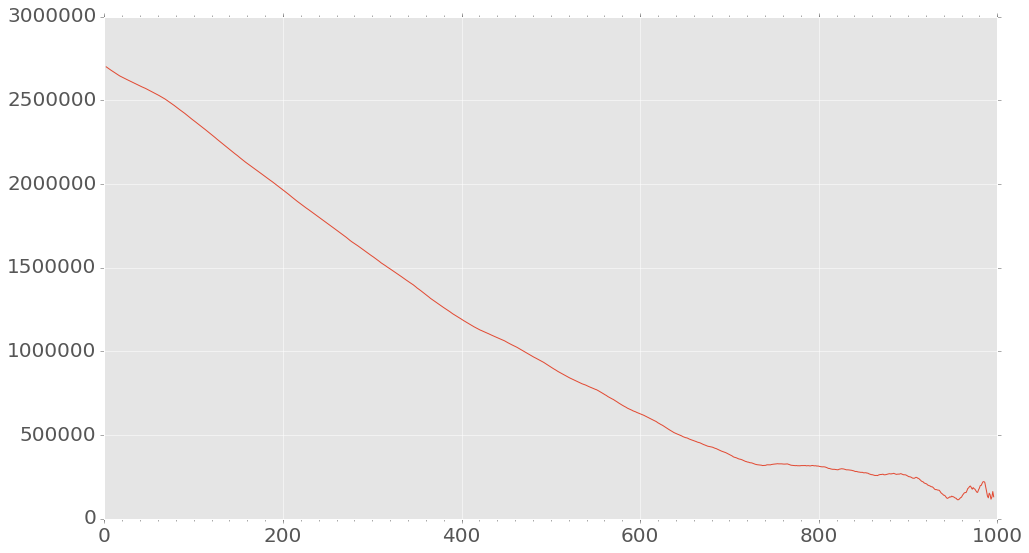

In [26]:
delta = []

end = 997
for i in xrange(2,end):
    new = getAverage(exp_I[i:])
    delta.append(sum(abs(debye_I[-2]-new)))
plt.plot(range(2,end),delta)
ax = plt.gca()
ax.xaxis.set_minor_locator(minorLocator)

# Variations on cube scattering

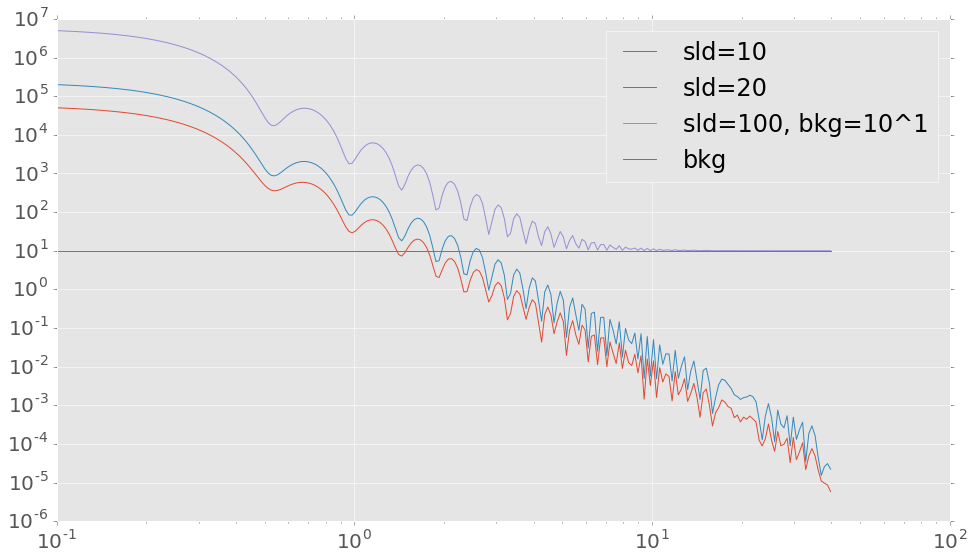

In [27]:
def cubeScatt(q,sld=10, box = 13.4,box2=6,bkg=0):#,box1w=1,box2w=.5):
    from _cube import lib
    I_cube = np.zeros_like(q)

    for i,Q in enumerate(q):
#         I_cube[i] = box1w*lib.Iq(Q,10,0,box,box,box)+box2w*lib.Iq(Q,10,0,box2,box2,box2)
        I_cube[i] = lib.Iq(Q,sld,0,box,box,box)+lib.Iq(Q,10,0,box2,box2,box2)+bkg
    return I_cube

cubeI = cubeScatt(exp_Q,10)
plt.loglog(exp_Q,cubeI,label='sld=10')
cubeI = cubeScatt(exp_Q,20)
plt.loglog(exp_Q,cubeI,label='sld=20')
cubeI = cubeScatt(exp_Q,100,bkg=10**1)
plt.loglog(exp_Q,cubeI,label='sld=100, bkg=10^1')
# plt.ylim([10**2,10**7])
plt.loglog(exp_Q,[10**1]*len(exp_Q),label='bkg')
plt.legend()


In [28]:
import numexpr as ne
import periodictable.cromermann as ptc

def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
def neSinc(x):
    a = ne.evaluate("sin(x)/x")
    indices=np.isnan(a)
    a[np.isnan(a)] = 1 - (x[indices]**2)/6 + (x[indices]**4)/120
    return a
1 - x^2/6 + x^4/120
coor = mol.coor()[-2]
pw = pairwise_numpy(coor)
Q_list  = np.logspace(-1,1.6,250)
I  = np.zeros_like(Q_list)
sld  = np.square(ptc.fxrayatq('Ar',Q_list))

for i,q in enumerate(Q_list):
    if(i%100==0): print (i)
    I[i] = np.sum(neSinc(q*pw))
plt.loglog(Q_list,I,alpha=.5)
plt.ylabel('Intensity')
plt.xlabel('Q')

NameError: name 'x' is not defined

In [ ]:
def neSinc(x):
    a = ne.evaluate("sin(x)/x")
    indices=np.isnan(a)
    a[np.isnan(a)] = 1 - (x[indices]**2)/6 + (x[indices]**4)/120
    return a
neSinc(np.array([0.001]))

In [ ]:
Qs  = np.logspace(-1,1.6,150)
def neSinc(x):
    x = np.asanyarray(x)
    y = np.where(x == 0, 1.0e-20, x)
    return  ne.evaluate("sin(y)/y")
#     indices=np.isnan(a)
#     a[np.isnan(a)] = 1 - (x[indices]**2)/6 + (x[indices]**4)/120
#     return a
# y = pi * where(x == 0, 1.0e-20, x)
def neLoop(Q):
    I  = np.zeros_like(Q)
    for i,q in enumerate(Q):
#         if(i%100==0): print (i)
        I[i] = np.sum(neSinc(q*pw))
    return I
def npLoop(Q):
    I  = np.zeros_like(Q)
    for i,q in enumerate(Q):
#         if(i%100==0): print (i)
        I[i] = np.sum(np.sinc(q*pw/np.pi))
    return I

def neDebye(coor,Qs):
    return _debye(coor,Qs)
def npDebye():
    """
    Slower than neDebye. Only diff is e-13 precision
    """
    return _debye(coor,Qs,False)
    
def _debye(coor, Qs,useNe=True):
    I = np.zeros((len(coor),len(Qs))) #frames,Qs
    if(useNe):
        for frame, dist in enumerate(coor):
            pw = pairwise_numpy(dist)
            for i,q in enumerate(Qs):
                I[frame][i] = np.sum(neSinc(q*pw))
    else:
        for frame, dist in enumerate(coor):
            pw = pairwise_numpy(dist)
            for i,q in enumerate(Qs):
                I[frame][i] = np.sum(np.sin(q*pw/np.pi))
    return I
neSinc(0)
# I_dby_ne = neDebye(mol.coor()[990:995],Qs)
# for i in I_dby_ne:
#     plt.loglog(Qs,i)

In [ ]:
%timeit neLoop(Qs)

In [ ]:
%timeit npLoop(Qs)

In [ ]:
neRes = neLoop(Qs)
npRes = npLoop(Qs)

In [ ]:
print(np.array_equal(npRes,neRes))
print(np.array_equiv(npRes,neRes))
print(np.isclose(npRes,neRes))
def avg(a,b):
    return (a+b)/2
print((npRes-neRes)/avg(npRes,neRes))

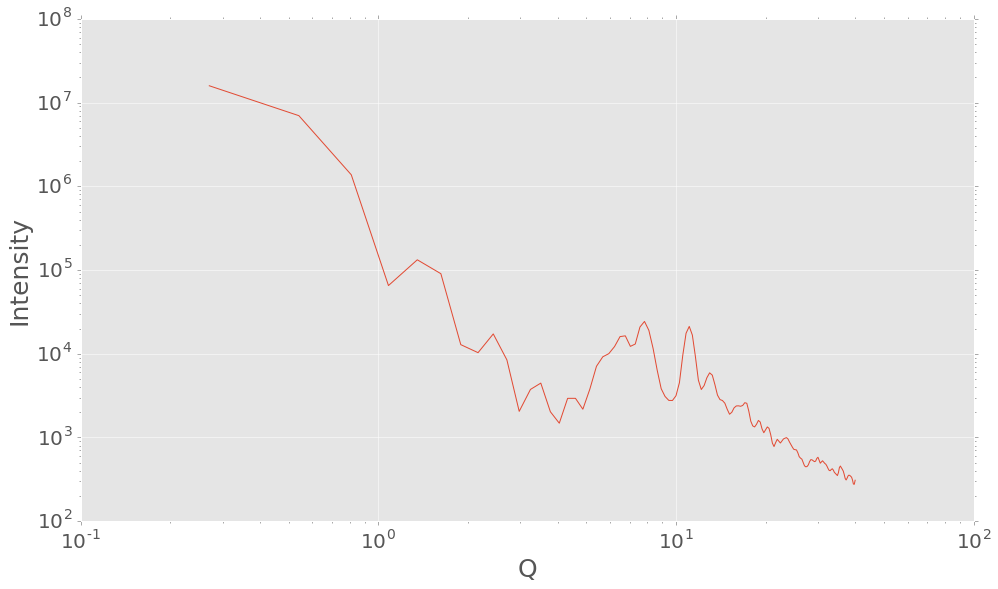

In [402]:
q,i  = np.loadtxt('../results_GVVV_python/shrunk-arg-6_gv149.iq',unpack=True)
plt.loglog(q,i)
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.show()

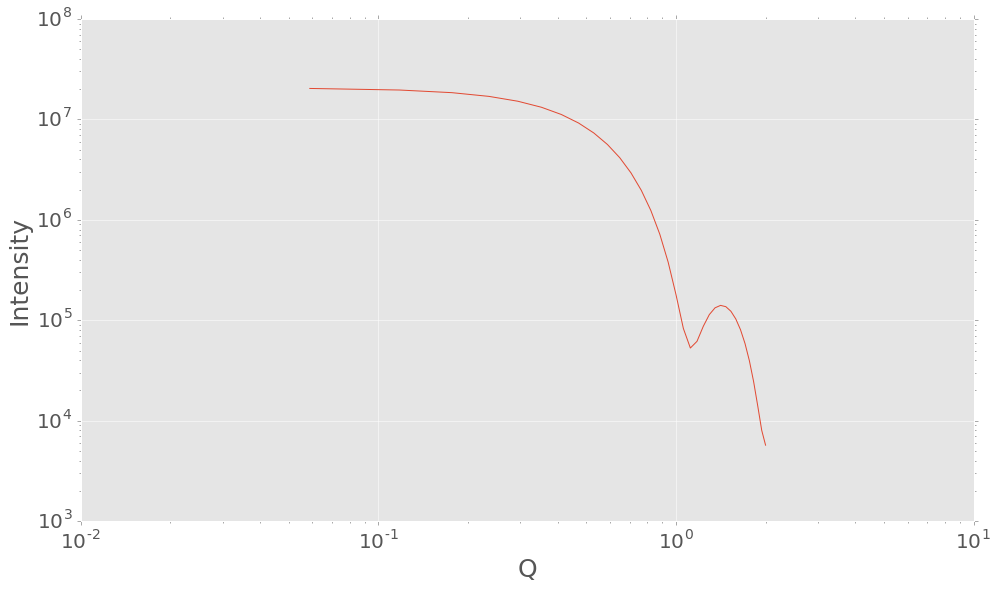

In [403]:
q,i  = np.loadtxt('../results_GVVV_python/shrunk-arg-6-debye.iq',unpack=True)
plt.loglog(q,i)
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.show()

In [ ]:
print(2*np.pi/1.5)
print(2*np.pi/0.5)

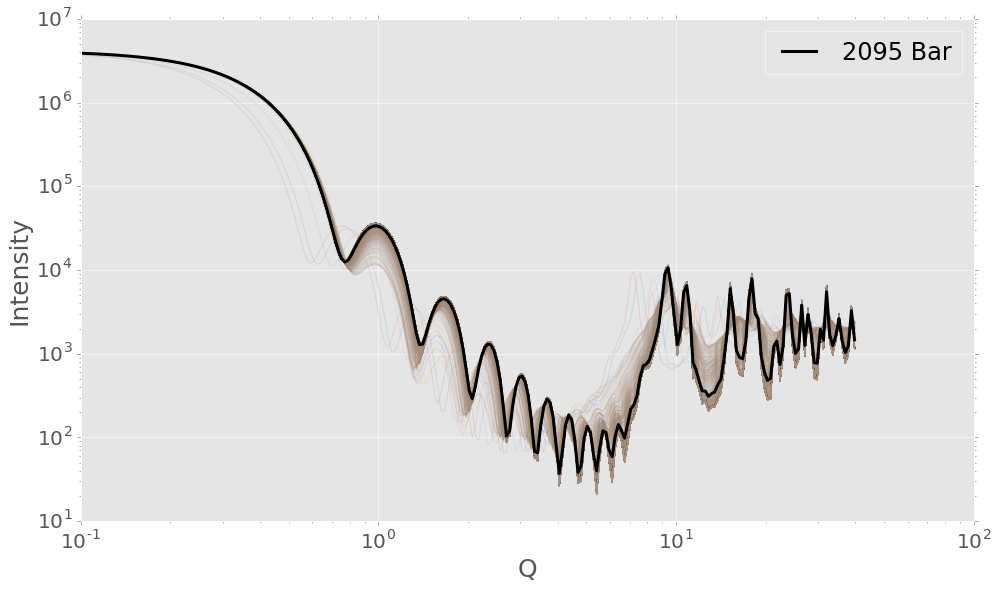

In [327]:
debye_I = np.load('/home/data/Outputs/2016-07-22_16-43/outPutI-Q250.npy')
debye_Q = np.load('/home/data/Outputs/2016-07-22_16-43/Q_list.npy')
debye_avg = getAverage(debye_I)
for i in debye_I:
    plt.loglog(debye_Q, i,alpha=.15)
plt.loglog(debye_Q,debye_avg,'k-',label='2095 Bar',lw=3)
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Q')
plt.show()

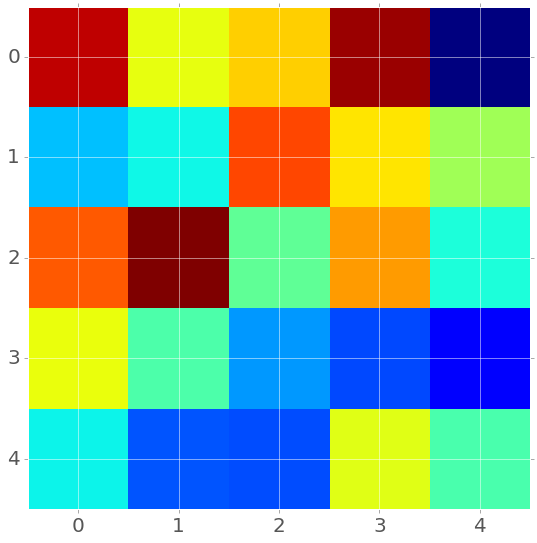

In [346]:
import matplotlib.pyplot as plt
import numpy as np

A = np.random.rand(5, 5)
plt.figure(1)
plt.imshow(A, interpolation='nearest')

plt.savefig('fig',format='svg')
plt.show()



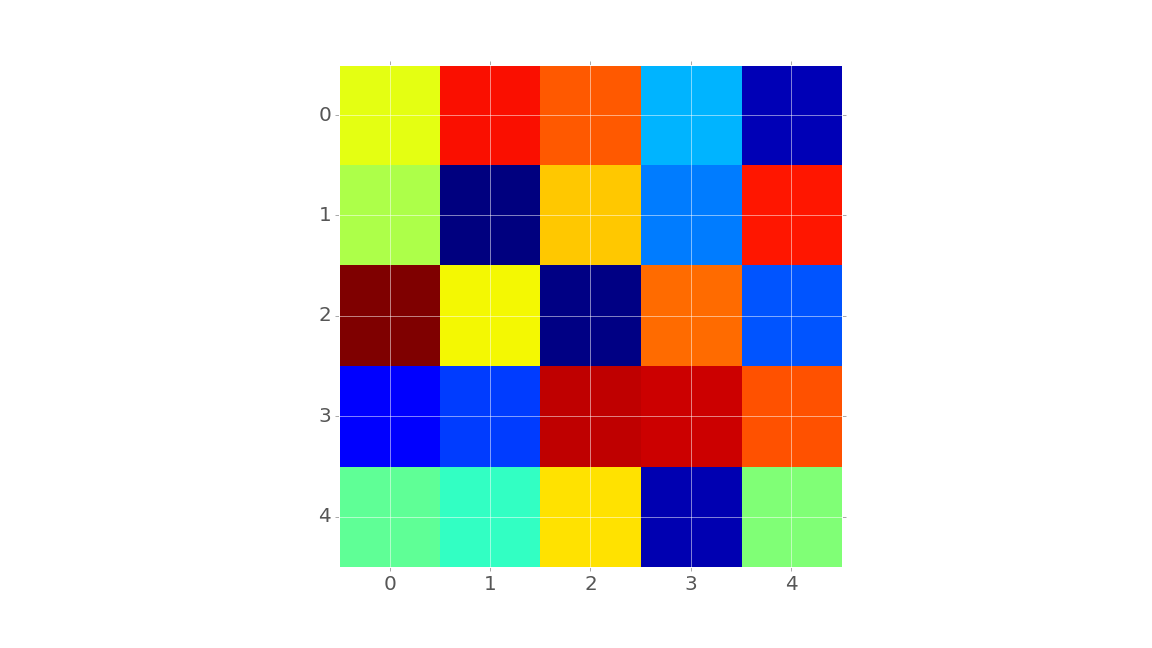

In [333]:
from IPython.display import Image
Image('fig.png')